In [2]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import data as dt
import model as md
import copy
from pytorch_ssim import ssim
from torch.utils.data import DataLoader
# e/d

In [3]:
# print gpu
torch.cuda.set_device(1)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 1
8
(6, 1)
1.0.0


In [4]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = "cpu"
print(device)

cuda:1


In [ ]:
# generate csv file, run only for the first time
# dt.generate_csv()

In [5]:
csvFilePath = dt.get_csv_path()
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(96),
                                               dt.Normalize(),
                                               dt.ToTensor()
                                           ]))
# TODO: change the normalization parameters

In [6]:
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

0 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
1 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
2 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
3 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


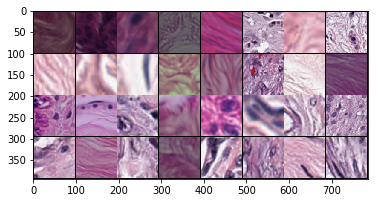

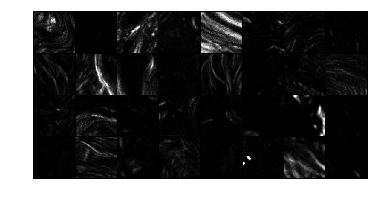

In [7]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [8]:
print('===> Building model')
model = md.Net().to(device)
criterionMSE = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


===> Building model


In [35]:
def train(epoch, p, windowsize):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)      
        lossSSIM = 1-ssim(output, targetf, window_size=windowsize)
        
        # 0.75->0.4 after 3 epochs
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossMSE: " + str(lossMSE.item()) +
                  " " + "lossSSIM: " + str(lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))


In [ ]:
# def test():
#     avg_psnr = 0
#     with torch.no_grad():
#         for batch in testing_data_loader:
#             input, target = batch[0].to(device), batch[1].to(device)

#             prediction = model(input)
#             mse = criterion(prediction, target)
#             psnr = 10 * log10(1 / mse.item())
#             avg_psnr += psnr
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


In [ ]:
# def checkpoint(epoch):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(model, model_out_path)
#     print("Checkpoint saved to {}".format(model_out_path))

In [12]:
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.2236083298921585 lossSSIM: 0.9521285891532898
===> Epoch[1](0/25343): Loss: 0.4057
lossMSE: 0.22643481194972992 lossSSIM: 0.9551966190338135
===> Epoch[1](50/25343): Loss: 0.4086
lossMSE: 0.2193039357662201 lossSSIM: 0.9519645571708679
===> Epoch[1](100/25343): Loss: 0.4025
lossMSE: 0.2190506011247635 lossSSIM: 0.9496465921401978
===> Epoch[1](150/25343): Loss: 0.4017
lossMSE: 0.2177480310201645 lossSSIM: 0.9515767693519592
===> Epoch[1](200/25343): Loss: 0.4012
lossMSE: 0.20641782879829407 lossSSIM: 0.9386119842529297
===> Epoch[1](250/25343): Loss: 0.3895
lossMSE: 0.2131938338279724 lossSSIM: 0.9519171118736267
===> Epoch[1](300/25343): Loss: 0.3979
lossMSE: 0.2124307006597519 lossSSIM: 0.9516014456748962
===> Epoch[1](350/25343): Loss: 0.3972
lossMSE: 0.2133532166481018 lossSSIM: 0.9542365074157715
===> Epoch[1](400/25343): Loss: 0.3986
lossMSE: 0.2092287391424179 lossSSIM: 0.9485486745834351
===> Epoch[1](450/25343): Loss: 0.3941
lossMSE: 0.21059627830982208 lossSSIM: 0.

lossMSE: 0.13670922815799713 lossSSIM: 0.9393953680992126
===> Epoch[1](4250/25343): Loss: 0.3374
lossMSE: 0.13267141580581665 lossSSIM: 0.9376250505447388
===> Epoch[1](4300/25343): Loss: 0.3339
lossMSE: 0.13077574968338013 lossSSIM: 0.9242864847183228
===> Epoch[1](4350/25343): Loss: 0.3292
lossMSE: 0.13244499266147614 lossSSIM: 0.932690441608429
===> Epoch[1](4400/25343): Loss: 0.3325
lossMSE: 0.13878054916858673 lossSSIM: 0.9471837878227234
===> Epoch[1](4450/25343): Loss: 0.3409
lossMSE: 0.1291639506816864 lossSSIM: 0.9310170412063599
===> Epoch[1](4500/25343): Loss: 0.3296
lossMSE: 0.12972848117351532 lossSSIM: 0.9338974356651306
===> Epoch[1](4550/25343): Loss: 0.3308
lossMSE: 0.1363593488931656 lossSSIM: 0.948695182800293
===> Epoch[1](4600/25343): Loss: 0.3394
lossMSE: 0.12712505459785461 lossSSIM: 0.9296424388885498
===> Epoch[1](4650/25343): Loss: 0.3278
lossMSE: 0.12911218404769897 lossSSIM: 0.940505862236023
===> Epoch[1](4700/25343): Loss: 0.3320
lossMSE: 0.12383101880550

lossMSE: 0.08005616068840027 lossSSIM: 0.92084801197052
===> Epoch[1](8450/25343): Loss: 0.2903
lossMSE: 0.08186832070350647 lossSSIM: 0.927537739276886
===> Epoch[1](8500/25343): Loss: 0.2933
lossMSE: 0.07991956174373627 lossSSIM: 0.9171780943870544
===> Epoch[1](8550/25343): Loss: 0.2892
lossMSE: 0.07648035883903503 lossSSIM: 0.9098098278045654
===> Epoch[1](8600/25343): Loss: 0.2848
lossMSE: 0.0791129469871521 lossSSIM: 0.9119542837142944
===> Epoch[1](8650/25343): Loss: 0.2873
lossMSE: 0.07959481328725815 lossSSIM: 0.9217629432678223
===> Epoch[1](8700/25343): Loss: 0.2901
lossMSE: 0.0790601596236229 lossSSIM: 0.9221605658531189
===> Epoch[1](8750/25343): Loss: 0.2898
lossMSE: 0.07533227652311325 lossSSIM: 0.9094471335411072
===> Epoch[1](8800/25343): Loss: 0.2839
lossMSE: 0.07549329847097397 lossSSIM: 0.9226122498512268
===> Epoch[1](8850/25343): Loss: 0.2873
lossMSE: 0.07622328400611877 lossSSIM: 0.9108262062072754
===> Epoch[1](8900/25343): Loss: 0.2849
lossMSE: 0.07316195964813

lossMSE: 0.045732464641332626 lossSSIM: 0.8886842727661133
===> Epoch[1](12650/25343): Loss: 0.2565
lossMSE: 0.04733969271183014 lossSSIM: 0.8978765606880188
===> Epoch[1](12700/25343): Loss: 0.2600
lossMSE: 0.0423714853823185 lossSSIM: 0.8759424090385437
===> Epoch[1](12750/25343): Loss: 0.2508
lossMSE: 0.04442284628748894 lossSSIM: 0.8872299790382385
===> Epoch[1](12800/25343): Loss: 0.2551
lossMSE: 0.04625470191240311 lossSSIM: 0.8943043947219849
===> Epoch[1](12850/25343): Loss: 0.2583
lossMSE: 0.043292202055454254 lossSSIM: 0.8822076320648193
===> Epoch[1](12900/25343): Loss: 0.2530
lossMSE: 0.04374659061431885 lossSSIM: 0.8919510245323181
===> Epoch[1](12950/25343): Loss: 0.2558
lossMSE: 0.04116857051849365 lossSSIM: 0.8809995651245117
===> Epoch[1](13000/25343): Loss: 0.2511
lossMSE: 0.044537562876939774 lossSSIM: 0.9020398259162903
===> Epoch[1](13050/25343): Loss: 0.2589
lossMSE: 0.04080763831734657 lossSSIM: 0.864517092704773
===> Epoch[1](13100/25343): Loss: 0.2467
lossMSE: 

lossMSE: 0.02904576063156128 lossSSIM: 0.8771364688873291
===> Epoch[1](16800/25343): Loss: 0.2411
lossMSE: 0.025524752214550972 lossSSIM: 0.8375843167304993
===> Epoch[1](16850/25343): Loss: 0.2285
lossMSE: 0.025828015059232712 lossSSIM: 0.8410090208053589
===> Epoch[1](16900/25343): Loss: 0.2296
lossMSE: 0.02520345151424408 lossSSIM: 0.8527064919471741
===> Epoch[1](16950/25343): Loss: 0.2321
lossMSE: 0.024990541860461235 lossSSIM: 0.863754391670227
===> Epoch[1](17000/25343): Loss: 0.2347
lossMSE: 0.02840331941843033 lossSSIM: 0.839538037776947
===> Epoch[1](17050/25343): Loss: 0.2312
lossMSE: 0.03213782608509064 lossSSIM: 0.870921790599823
===> Epoch[1](17100/25343): Loss: 0.2418
lossMSE: 0.02588384598493576 lossSSIM: 0.8750680685043335
===> Epoch[1](17150/25343): Loss: 0.2382
lossMSE: 0.024070754647254944 lossSSIM: 0.8333703279495239
===> Epoch[1](17200/25343): Loss: 0.2264
lossMSE: 0.024234257638454437 lossSSIM: 0.8243420124053955
===> Epoch[1](17250/25343): Loss: 0.2243
lossMSE:

lossMSE: 0.016486169770359993 lossSSIM: 0.7503995895385742
===> Epoch[1](20950/25343): Loss: 0.2000
lossMSE: 0.016962263733148575 lossSSIM: 0.8046496510505676
===> Epoch[1](21000/25343): Loss: 0.2139
lossMSE: 0.020596930757164955 lossSSIM: 0.7519906759262085
===> Epoch[1](21050/25343): Loss: 0.2034
lossMSE: 0.01869705691933632 lossSSIM: 0.8084458112716675
===> Epoch[1](21100/25343): Loss: 0.2161
lossMSE: 0.01929977349936962 lossSSIM: 0.7935781478881836
===> Epoch[1](21150/25343): Loss: 0.2129
lossMSE: 0.016350699588656425 lossSSIM: 0.7797596454620361
===> Epoch[1](21200/25343): Loss: 0.2072
lossMSE: 0.018312828615307808 lossSSIM: 0.7775135636329651
===> Epoch[1](21250/25343): Loss: 0.2081
lossMSE: 0.016913142055273056 lossSSIM: 0.7475007176399231
===> Epoch[1](21300/25343): Loss: 0.1996
lossMSE: 0.016649482771754265 lossSSIM: 0.7253667116165161
===> Epoch[1](21350/25343): Loss: 0.1938
lossMSE: 0.01588626205921173 lossSSIM: 0.7543613910675049
===> Epoch[1](21400/25343): Loss: 0.2005
los

lossMSE: 0.014419879764318466 lossSSIM: 0.640129804611206
===> Epoch[1](25100/25343): Loss: 0.1708
lossMSE: 0.0158570297062397 lossSSIM: 0.6841727495193481
===> Epoch[1](25150/25343): Loss: 0.1829
lossMSE: 0.013970481231808662 lossSSIM: 0.6689863204956055
===> Epoch[1](25200/25343): Loss: 0.1777
lossMSE: 0.013557087630033493 lossSSIM: 0.6687588095664978
===> Epoch[1](25250/25343): Loss: 0.1774
lossMSE: 0.013608871959149837 lossSSIM: 0.6435325145721436
===> Epoch[1](25300/25343): Loss: 0.1711
===> Epoch 1 Complete: Avg. Loss: 0.2686
lossMSE: 0.014305021613836288 lossSSIM: 0.6639020442962646
===> Epoch[2](0/25343): Loss: 0.1767
lossMSE: 0.013263351283967495 lossSSIM: 0.648558497428894
===> Epoch[2](50/25343): Loss: 0.1721
lossMSE: 0.013801191933453083 lossSSIM: 0.6524527072906494
===> Epoch[2](100/25343): Loss: 0.1735
lossMSE: 0.012776627205312252 lossSSIM: 0.6505331993103027
===> Epoch[2](150/25343): Loss: 0.1722
lossMSE: 0.013698760420084 lossSSIM: 0.6200186014175415
===> Epoch[2](200/

lossMSE: 0.014354228973388672 lossSSIM: 0.5108766555786133
===> Epoch[2](3900/25343): Loss: 0.1385
lossMSE: 0.012409135699272156 lossSSIM: 0.5210134983062744
===> Epoch[2](3950/25343): Loss: 0.1396
lossMSE: 0.01248917356133461 lossSSIM: 0.5273481607437134
===> Epoch[2](4000/25343): Loss: 0.1412
lossMSE: 0.015621500089764595 lossSSIM: 0.5231768488883972
===> Epoch[2](4050/25343): Loss: 0.1425
lossMSE: 0.0138079933822155 lossSSIM: 0.5357787609100342
===> Epoch[2](4100/25343): Loss: 0.1443
lossMSE: 0.013485321775078773 lossSSIM: 0.5361129641532898
===> Epoch[2](4150/25343): Loss: 0.1441
lossMSE: 0.013523982837796211 lossSSIM: 0.5028262734413147
===> Epoch[2](4200/25343): Loss: 0.1358
lossMSE: 0.013852808624505997 lossSSIM: 0.520383358001709
===> Epoch[2](4250/25343): Loss: 0.1405
lossMSE: 0.013120346702635288 lossSSIM: 0.5126024484634399
===> Epoch[2](4300/25343): Loss: 0.1380
lossMSE: 0.01524224504828453 lossSSIM: 0.524026095867157
===> Epoch[2](4350/25343): Loss: 0.1424
lossMSE: 0.01515

lossMSE: 0.012590880505740643 lossSSIM: 0.4526217579841614
===> Epoch[2](8050/25343): Loss: 0.1226
lossMSE: 0.014447029680013657 lossSSIM: 0.4551613926887512
===> Epoch[2](8100/25343): Loss: 0.1246
lossMSE: 0.01039397157728672 lossSSIM: 0.41343873739242554
===> Epoch[2](8150/25343): Loss: 0.1112
lossMSE: 0.009992185980081558 lossSSIM: 0.4280949831008911
===> Epoch[2](8200/25343): Loss: 0.1145
lossMSE: 0.01074473187327385 lossSSIM: 0.41449427604675293
===> Epoch[2](8250/25343): Loss: 0.1117
lossMSE: 0.010604116134345531 lossSSIM: 0.4126567840576172
===> Epoch[2](8300/25343): Loss: 0.1111
lossMSE: 0.01274462416768074 lossSSIM: 0.43424683809280396
===> Epoch[2](8350/25343): Loss: 0.1181
lossMSE: 0.010416613891720772 lossSSIM: 0.4218027591705322
===> Epoch[2](8400/25343): Loss: 0.1133
lossMSE: 0.015206413343548775 lossSSIM: 0.43042469024658203
===> Epoch[2](8450/25343): Loss: 0.1190
lossMSE: 0.011771542020142078 lossSSIM: 0.4412039518356323
===> Epoch[2](8500/25343): Loss: 0.1191
lossMSE: 

lossMSE: 0.00795714557170868 lossSSIM: 0.34654831886291504
===> Epoch[2](12200/25343): Loss: 0.0926
lossMSE: 0.00708944583311677 lossSSIM: 0.3674570322036743
===> Epoch[2](12250/25343): Loss: 0.0972
lossMSE: 0.010632402263581753 lossSSIM: 0.35085779428482056
===> Epoch[2](12300/25343): Loss: 0.0957
lossMSE: 0.007187697570770979 lossSSIM: 0.353030264377594
===> Epoch[2](12350/25343): Loss: 0.0936
lossMSE: 0.007033708970993757 lossSSIM: 0.3500668406486511
===> Epoch[2](12400/25343): Loss: 0.0928
lossMSE: 0.009775987826287746 lossSSIM: 0.3845157027244568
===> Epoch[2](12450/25343): Loss: 0.1035
lossMSE: 0.006129915826022625 lossSSIM: 0.3630755543708801
===> Epoch[2](12500/25343): Loss: 0.0954
lossMSE: 0.010115615092217922 lossSSIM: 0.3563000559806824
===> Epoch[2](12550/25343): Loss: 0.0967
lossMSE: 0.010204918682575226 lossSSIM: 0.35118311643600464
===> Epoch[2](12600/25343): Loss: 0.0954
lossMSE: 0.00995582528412342 lossSSIM: 0.3541443943977356
===> Epoch[2](12650/25343): Loss: 0.0960
l

lossMSE: 0.0046984064392745495 lossSSIM: 0.3129519820213318
===> Epoch[2](16300/25343): Loss: 0.0818
lossMSE: 0.006114736199378967 lossSSIM: 0.2974774241447449
===> Epoch[2](16350/25343): Loss: 0.0790
lossMSE: 0.007160615641623735 lossSSIM: 0.2647779583930969
===> Epoch[2](16400/25343): Loss: 0.0716
lossMSE: 0.005751582328230143 lossSSIM: 0.2849356532096863
===> Epoch[2](16450/25343): Loss: 0.0755
lossMSE: 0.007176028564572334 lossSSIM: 0.2841693162918091
===> Epoch[2](16500/25343): Loss: 0.0764
lossMSE: 0.005781001411378384 lossSSIM: 0.30222511291503906
===> Epoch[2](16550/25343): Loss: 0.0799
lossMSE: 0.006231376901268959 lossSSIM: 0.2923816442489624
===> Epoch[2](16600/25343): Loss: 0.0778
lossMSE: 0.00949754286557436 lossSSIM: 0.33905982971191406
===> Epoch[2](16650/25343): Loss: 0.0919
lossMSE: 0.006078111007809639 lossSSIM: 0.3097380995750427
===> Epoch[2](16700/25343): Loss: 0.0820
lossMSE: 0.014982400462031364 lossSSIM: 0.3522590398788452
===> Epoch[2](16750/25343): Loss: 0.099

lossMSE: 0.0065245055593550205 lossSSIM: 0.28767794370651245
===> Epoch[2](20400/25343): Loss: 0.0768
lossMSE: 0.003338283859193325 lossSSIM: 0.2819522023200989
===> Epoch[2](20450/25343): Loss: 0.0730
lossMSE: 0.008276443928480148 lossSSIM: 0.2954952120780945
===> Epoch[2](20500/25343): Loss: 0.0801
lossMSE: 0.005291362758725882 lossSSIM: 0.2600456476211548
===> Epoch[2](20550/25343): Loss: 0.0690
lossMSE: 0.008410144597291946 lossSSIM: 0.27506178617477417
===> Epoch[2](20600/25343): Loss: 0.0751
lossMSE: 0.006765847560018301 lossSSIM: 0.3332369923591614
===> Epoch[2](20650/25343): Loss: 0.0884
lossMSE: 0.015568612143397331 lossSSIM: 0.2689414620399475
===> Epoch[2](20700/25343): Loss: 0.0789
lossMSE: 0.0031691426411271095 lossSSIM: 0.24463021755218506
===> Epoch[2](20750/25343): Loss: 0.0635
lossMSE: 0.003970829304307699 lossSSIM: 0.28040629625320435
===> Epoch[2](20800/25343): Loss: 0.0731
lossMSE: 0.010089335963129997 lossSSIM: 0.29253530502319336
===> Epoch[2](20850/25343): Loss: 

lossMSE: 0.0061204200610518456 lossSSIM: 0.3229966163635254
===> Epoch[2](24500/25343): Loss: 0.0853
lossMSE: 0.007229646667838097 lossSSIM: 0.29790687561035156
===> Epoch[2](24550/25343): Loss: 0.0799
lossMSE: 0.007699953392148018 lossSSIM: 0.2554793357849121
===> Epoch[2](24600/25343): Loss: 0.0696
lossMSE: 0.0048804935067892075 lossSSIM: 0.24223536252975464
===> Epoch[2](24650/25343): Loss: 0.0642
lossMSE: 0.007829205133020878 lossSSIM: 0.30843424797058105
===> Epoch[2](24700/25343): Loss: 0.0830
lossMSE: 0.003830274799838662 lossSSIM: 0.2505371570587158
===> Epoch[2](24750/25343): Loss: 0.0655
lossMSE: 0.004213789012283087 lossSSIM: 0.2496098279953003
===> Epoch[2](24800/25343): Loss: 0.0656
lossMSE: 0.005460390821099281 lossSSIM: 0.2755623459815979
===> Epoch[2](24850/25343): Loss: 0.0730
lossMSE: 0.008133122697472572 lossSSIM: 0.32362908124923706
===> Epoch[2](24900/25343): Loss: 0.0870
lossMSE: 0.0028392253443598747 lossSSIM: 0.2183976173400879
===> Epoch[2](24950/25343): Loss: 

lossMSE: 0.0023392969742417336 lossSSIM: 0.21593862771987915
===> Epoch[3](3250/25343): Loss: 0.0557
lossMSE: 0.005161569453775883 lossSSIM: 0.2529972791671753
===> Epoch[3](3300/25343): Loss: 0.0671
lossMSE: 0.008866348303854465 lossSSIM: 0.27335065603256226
===> Epoch[3](3350/25343): Loss: 0.0750
lossMSE: 0.006888045929372311 lossSSIM: 0.24857789278030396
===> Epoch[3](3400/25343): Loss: 0.0673
lossMSE: 0.0030673500150442123 lossSSIM: 0.2740274667739868
===> Epoch[3](3450/25343): Loss: 0.0708
lossMSE: 0.008755938149988651 lossSSIM: 0.33170825242996216
===> Epoch[3](3500/25343): Loss: 0.0895
lossMSE: 0.009855072945356369 lossSSIM: 0.30684977769851685
===> Epoch[3](3550/25343): Loss: 0.0841
lossMSE: 0.003923927899450064 lossSSIM: 0.21747606992721558
===> Epoch[3](3600/25343): Loss: 0.0573
lossMSE: 0.004195266868919134 lossSSIM: 0.2695479393005371
===> Epoch[3](3650/25343): Loss: 0.0705
lossMSE: 0.006024549249559641 lossSSIM: 0.3037327527999878
===> Epoch[3](3700/25343): Loss: 0.0805
lo

lossMSE: 0.005068617407232523 lossSSIM: 0.25117355585098267
===> Epoch[3](7400/25343): Loss: 0.0666
lossMSE: 0.004868669901043177 lossSSIM: 0.21382910013198853
===> Epoch[3](7450/25343): Loss: 0.0571
lossMSE: 0.0046758768148720264 lossSSIM: 0.2550024390220642
===> Epoch[3](7500/25343): Loss: 0.0673
lossMSE: 0.005163328722119331 lossSSIM: 0.24442213773727417
===> Epoch[3](7550/25343): Loss: 0.0650
lossMSE: 0.00999448075890541 lossSSIM: 0.32027703523635864
===> Epoch[3](7600/25343): Loss: 0.0876
lossMSE: 0.003845820901915431 lossSSIM: 0.22788578271865845
===> Epoch[3](7650/25343): Loss: 0.0599
lossMSE: 0.012136164121329784 lossSSIM: 0.26921987533569336
===> Epoch[3](7700/25343): Loss: 0.0764
lossMSE: 0.010255550965666771 lossSSIM: 0.26655644178390503
===> Epoch[3](7750/25343): Loss: 0.0743
lossMSE: 0.003919104114174843 lossSSIM: 0.21682512760162354
===> Epoch[3](7800/25343): Loss: 0.0571
lossMSE: 0.005730117205530405 lossSSIM: 0.24697619676589966
===> Epoch[3](7850/25343): Loss: 0.0660
l

lossMSE: 0.014173964969813824 lossSSIM: 0.3254772424697876
===> Epoch[3](11500/25343): Loss: 0.0920
lossMSE: 0.006325217429548502 lossSSIM: 0.22417813539505005
===> Epoch[3](11550/25343): Loss: 0.0608
lossMSE: 0.00804896093904972 lossSSIM: 0.3164365887641907
===> Epoch[3](11600/25343): Loss: 0.0851
lossMSE: 0.002080788603052497 lossSSIM: 0.23420816659927368
===> Epoch[3](11650/25343): Loss: 0.0601
lossMSE: 0.013634390197694302 lossSSIM: 0.32780444622039795
===> Epoch[3](11700/25343): Loss: 0.0922
lossMSE: 0.012181892991065979 lossSSIM: 0.34202396869659424
===> Epoch[3](11750/25343): Loss: 0.0946
lossMSE: 0.012414350174367428 lossSSIM: 0.3787221908569336
===> Epoch[3](11800/25343): Loss: 0.1040
lossMSE: 0.0046412330120801926 lossSSIM: 0.2722587585449219
===> Epoch[3](11850/25343): Loss: 0.0715
lossMSE: 0.008806543424725533 lossSSIM: 0.3062688112258911
===> Epoch[3](11900/25343): Loss: 0.0832
lossMSE: 0.003028284525498748 lossSSIM: 0.25874364376068115
===> Epoch[3](11950/25343): Loss: 0.

lossMSE: 0.013957221992313862 lossSSIM: 0.31833475828170776
===> Epoch[3](15600/25343): Loss: 0.0901
lossMSE: 0.009832567535340786 lossSSIM: 0.29249829053878784
===> Epoch[3](15650/25343): Loss: 0.0805
lossMSE: 0.01117341872304678 lossSSIM: 0.24621689319610596
===> Epoch[3](15700/25343): Loss: 0.0699
lossMSE: 0.002750615356490016 lossSSIM: 0.20654141902923584
===> Epoch[3](15750/25343): Loss: 0.0537
lossMSE: 0.007836231961846352 lossSSIM: 0.2871915102005005
===> Epoch[3](15800/25343): Loss: 0.0777
lossMSE: 0.009255912154912949 lossSSIM: 0.296583890914917
===> Epoch[3](15850/25343): Loss: 0.0811
lossMSE: 0.0042783417738974094 lossSSIM: 0.2905982732772827
===> Epoch[3](15900/25343): Loss: 0.0759
lossMSE: 0.004864477552473545 lossSSIM: 0.28217506408691406
===> Epoch[3](15950/25343): Loss: 0.0742
lossMSE: 0.013892938382923603 lossSSIM: 0.3346042037010193
===> Epoch[3](16000/25343): Loss: 0.0941
lossMSE: 0.008163548074662685 lossSSIM: 0.3211326003074646
===> Epoch[3](16050/25343): Loss: 0.0

KeyboardInterrupt: 

In [44]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
                
            prediction = model(input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            batch_size = 32
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
#             for img in input_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)
                            
#             for img in label_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)
            grid = utils.make_grid(input).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
            targetf = target[:, None]
            
            lossMSE = criterionMSE(prediction, targetf)      
            lossSSIM = -ssim(prediction, targetf)
        
            p = 0.25
            loss = p*lossMSE + (1-p)*lossSSIM
            combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
#             mse = criterion(prediction, target.float())

            psnr = 10 * torch.log10(1 / loss)
            avg_psnr += psnr
            if iteration == 16:
                break
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


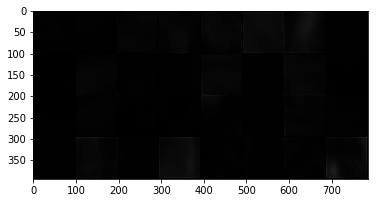

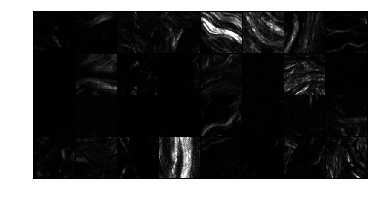

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


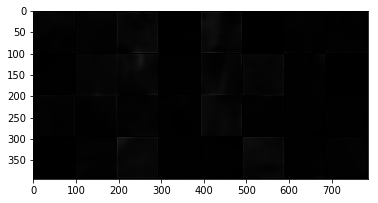

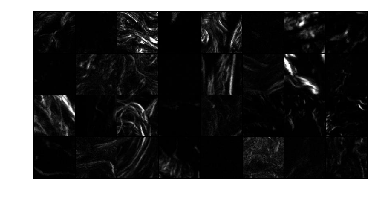

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


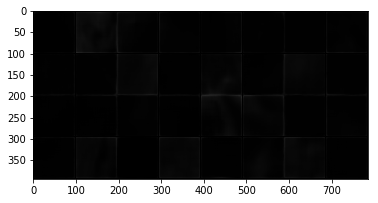

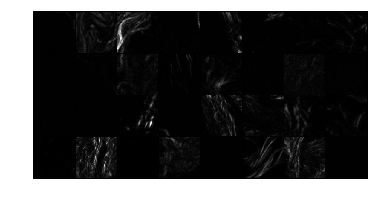

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


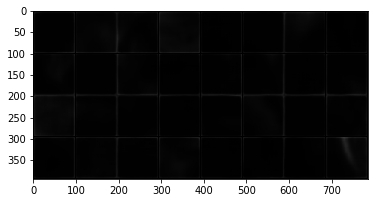

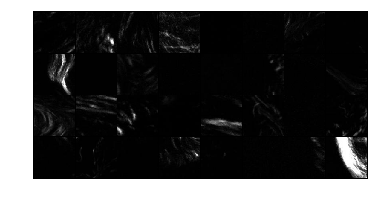

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


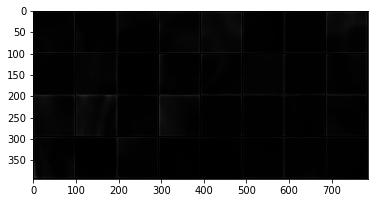

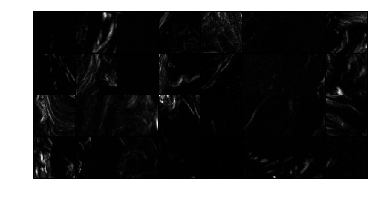

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


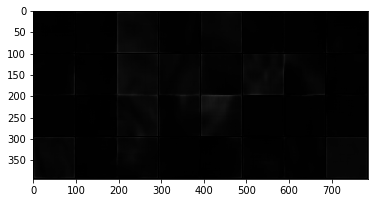

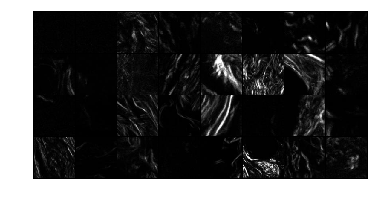

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


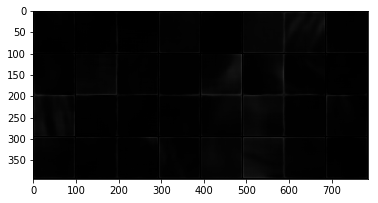

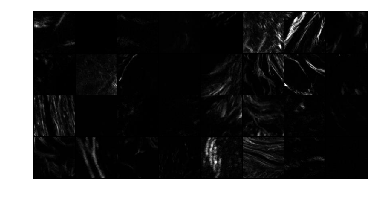

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


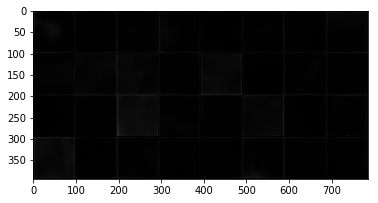

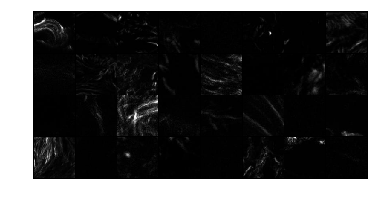

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


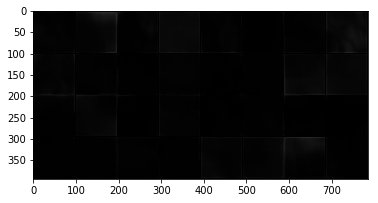

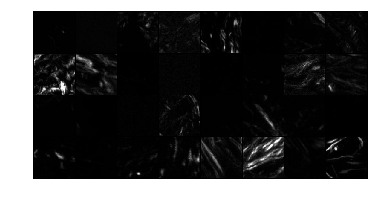

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


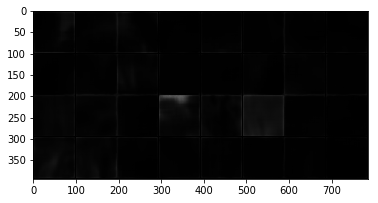

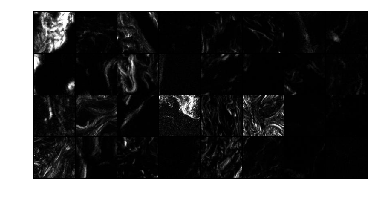

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


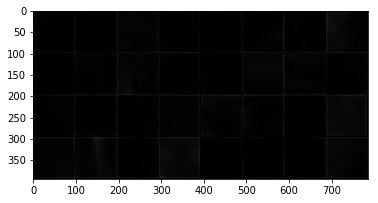

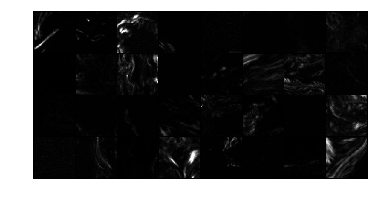

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


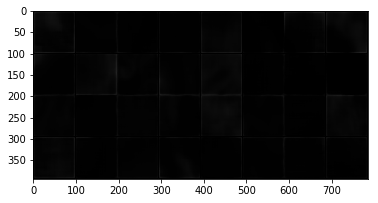

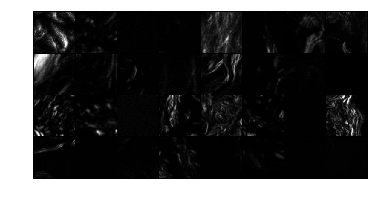

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


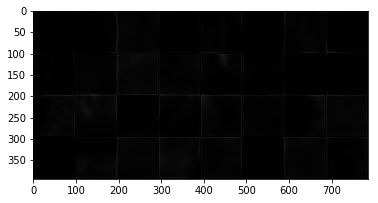

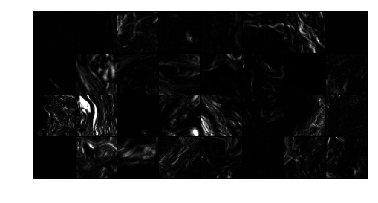

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


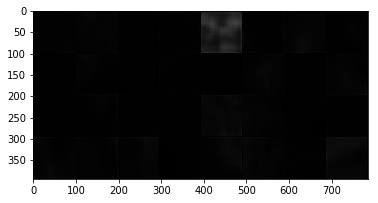

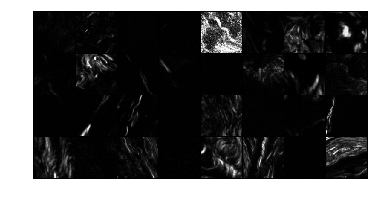

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


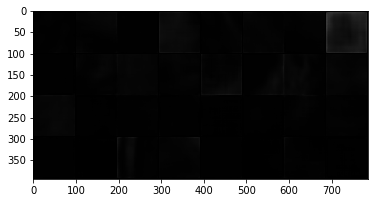

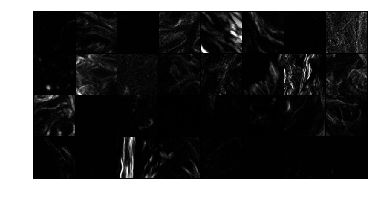

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


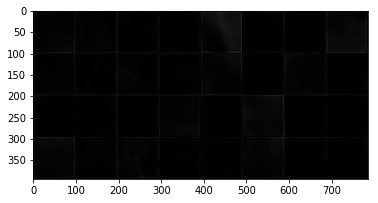

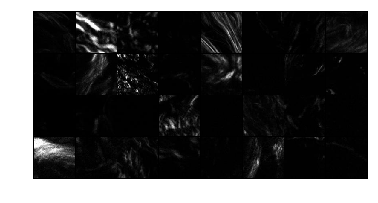

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


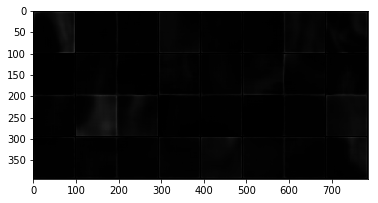

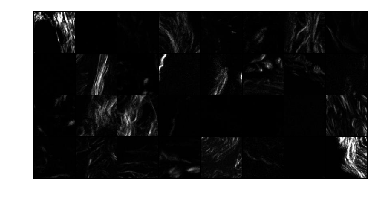

===> Avg. PSNR: nan dB


In [17]:
test()

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [19]:
for epoch in range(1, 20 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.007945235818624496 lossSSIM: 0.33534836769104004
===> Epoch[1](0/25343): Loss: 0.0898
lossMSE: 0.004066476598381996 lossSSIM: 0.24238532781600952
===> Epoch[1](50/25343): Loss: 0.0636
lossMSE: 0.004077968653291464 lossSSIM: 0.28258079290390015
===> Epoch[1](100/25343): Loss: 0.0737
lossMSE: 0.0071484679356217384 lossSSIM: 0.2803799510002136
===> Epoch[1](150/25343): Loss: 0.0755
lossMSE: 0.007389293052256107 lossSSIM: 0.24005627632141113
===> Epoch[1](200/25343): Loss: 0.0656
lossMSE: 0.0029260257724672556 lossSSIM: 0.1864500641822815
===> Epoch[1](250/25343): Loss: 0.0488
lossMSE: 0.0061559476889669895 lossSSIM: 0.2170008420944214
===> Epoch[1](300/25343): Loss: 0.0589
lossMSE: 0.015139126218855381 lossSSIM: 0.3245932459831238
===> Epoch[1](350/25343): Loss: 0.0925
lossMSE: 0.012857704423367977 lossSSIM: 0.34839117527008057
===> Epoch[1](400/25343): Loss: 0.0967
lossMSE: 0.007677312474697828 lossSSIM: 0.2671933174133301
===> Epoch[1](450/25343): Loss: 0.0726
lossMSE: 0.0036

KeyboardInterrupt: 

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [21]:
for epoch in range(1, 20 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.00451630586758256 lossSSIM: 0.2781749367713928
===> Epoch[1](0/25343): Loss: 0.0729
lossMSE: 0.012334968894720078 lossSSIM: 0.3792368173599243
===> Epoch[1](50/25343): Loss: 0.1041
lossMSE: 0.014667532406747341 lossSSIM: 0.29796355962753296
===> Epoch[1](100/25343): Loss: 0.0855
lossMSE: 0.007166301365941763 lossSSIM: 0.31486523151397705
===> Epoch[1](150/25343): Loss: 0.0841
lossMSE: 0.007320455275475979 lossSSIM: 0.27221840620040894
===> Epoch[1](200/25343): Loss: 0.0735
lossMSE: 0.0050432113930583 lossSSIM: 0.3198395371437073
===> Epoch[1](250/25343): Loss: 0.0837
lossMSE: 0.005131853744387627 lossSSIM: 0.25063556432724
===> Epoch[1](300/25343): Loss: 0.0665
lossMSE: 0.006202658172696829 lossSSIM: 0.2805887460708618
===> Epoch[1](350/25343): Loss: 0.0748
lossMSE: 0.008176160044968128 lossSSIM: 0.3171144127845764
===> Epoch[1](400/25343): Loss: 0.0854
lossMSE: 0.007162471767514944 lossSSIM: 0.337712824344635
===> Epoch[1](450/25343): Loss: 0.0898
lossMSE: 0.003518610028550

KeyboardInterrupt: 

In [42]:
# batchsize 32->128
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

In [28]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [29]:
for epoch in range(1, 10 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)
#   p: 0.75->0.4

lossMSE: 0.006628135219216347 lossSSIM: 0.27069270610809326
===> Epoch[1](0/12672): Loss: 0.1651
lossMSE: 0.012355188839137554 lossSSIM: 0.3338363766670227
===> Epoch[1](50/12672): Loss: 0.2052
lossMSE: 0.00647505559027195 lossSSIM: 0.28285324573516846
===> Epoch[1](100/12672): Loss: 0.1723
lossMSE: 0.004710515029728413 lossSSIM: 0.23462313413619995
===> Epoch[1](150/12672): Loss: 0.1427
lossMSE: 0.008397608995437622 lossSSIM: 0.2900369167327881
===> Epoch[1](200/12672): Loss: 0.1774
lossMSE: 0.004393624607473612 lossSSIM: 0.2725712060928345
===> Epoch[1](250/12672): Loss: 0.1653
lossMSE: 0.007149954792112112 lossSSIM: 0.29467499256134033
===> Epoch[1](300/12672): Loss: 0.1797
lossMSE: 0.012229456566274166 lossSSIM: 0.3426175117492676
===> Epoch[1](350/12672): Loss: 0.2105
lossMSE: 0.005184449255466461 lossSSIM: 0.2668694257736206
===> Epoch[1](400/12672): Loss: 0.1622
lossMSE: 0.00963525753468275 lossSSIM: 0.2704867124557495
===> Epoch[1](450/12672): Loss: 0.1661
lossMSE: 0.0083799250

lossMSE: 0.005376753397285938 lossSSIM: 0.25341904163360596
===> Epoch[1](4150/12672): Loss: 0.1542
lossMSE: 0.009690907783806324 lossSSIM: 0.28546369075775146
===> Epoch[1](4200/12672): Loss: 0.1752
lossMSE: 0.010107623413205147 lossSSIM: 0.3210441470146179
===> Epoch[1](4250/12672): Loss: 0.1967
lossMSE: 0.00803953967988491 lossSSIM: 0.307047963142395
===> Epoch[1](4300/12672): Loss: 0.1874
lossMSE: 0.006501349154859781 lossSSIM: 0.27268511056900024
===> Epoch[1](4350/12672): Loss: 0.1662
lossMSE: 0.006909474264830351 lossSSIM: 0.25392472743988037
===> Epoch[1](4400/12672): Loss: 0.1551
lossMSE: 0.013735810294747353 lossSSIM: 0.3371453285217285
===> Epoch[1](4450/12672): Loss: 0.2078
lossMSE: 0.005699453875422478 lossSSIM: 0.2794218063354492
===> Epoch[1](4500/12672): Loss: 0.1699
lossMSE: 0.00516755785793066 lossSSIM: 0.23628908395767212
===> Epoch[1](4550/12672): Loss: 0.1438
lossMSE: 0.008453824557363987 lossSSIM: 0.282524049282074
===> Epoch[1](4600/12672): Loss: 0.1729
lossMSE: 

lossMSE: 0.006682763807475567 lossSSIM: 0.276020348072052
===> Epoch[1](8300/12672): Loss: 0.1683
lossMSE: 0.005500409286469221 lossSSIM: 0.2734360694885254
===> Epoch[1](8350/12672): Loss: 0.1663
lossMSE: 0.005970293655991554 lossSSIM: 0.2777137756347656
===> Epoch[1](8400/12672): Loss: 0.1690
lossMSE: 0.007735470775514841 lossSSIM: 0.30787479877471924
===> Epoch[1](8450/12672): Loss: 0.1878
lossMSE: 0.0076001351699233055 lossSSIM: 0.3242518901824951
===> Epoch[1](8500/12672): Loss: 0.1976
lossMSE: 0.006051091011613607 lossSSIM: 0.26839810609817505
===> Epoch[1](8550/12672): Loss: 0.1635
lossMSE: 0.00839095190167427 lossSSIM: 0.31016290187835693
===> Epoch[1](8600/12672): Loss: 0.1895
lossMSE: 0.006750250700861216 lossSSIM: 0.2921399474143982
===> Epoch[1](8650/12672): Loss: 0.1780
lossMSE: 0.007421515882015228 lossSSIM: 0.2584956884384155
===> Epoch[1](8700/12672): Loss: 0.1581
lossMSE: 0.01008373312652111 lossSSIM: 0.3093125820159912
===> Epoch[1](8750/12672): Loss: 0.1896
lossMSE: 

lossMSE: 0.006680699530988932 lossSSIM: 0.25072598457336426
===> Epoch[1](12450/12672): Loss: 0.1531
lossMSE: 0.004286604002118111 lossSSIM: 0.24674981832504272
===> Epoch[1](12500/12672): Loss: 0.1498
lossMSE: 0.013188138604164124 lossSSIM: 0.2890433669090271
===> Epoch[1](12550/12672): Loss: 0.1787
lossMSE: 0.005478466395288706 lossSSIM: 0.2489345669746399
===> Epoch[1](12600/12672): Loss: 0.1516
lossMSE: 0.006410668138414621 lossSSIM: 0.28819018602371216
===> Epoch[1](12650/12672): Loss: 0.1755
===> Epoch 1 Complete: Avg. Loss: 0.1688
lossMSE: 0.003801817772909999 lossSSIM: 0.2683888077735901
===> Epoch[2](0/12672): Loss: 0.1626
lossMSE: 0.007412710227072239 lossSSIM: 0.25993460416793823
===> Epoch[2](50/12672): Loss: 0.1589
lossMSE: 0.006428766530007124 lossSSIM: 0.28978949785232544
===> Epoch[2](100/12672): Loss: 0.1764
lossMSE: 0.003932386636734009 lossSSIM: 0.2783128023147583
===> Epoch[2](150/12672): Loss: 0.1686
lossMSE: 0.0032860818319022655 lossSSIM: 0.2248653769493103
===> 

lossMSE: 0.00638301158323884 lossSSIM: 0.24537676572799683
===> Epoch[2](3900/12672): Loss: 0.1498
lossMSE: 0.003934717737138271 lossSSIM: 0.1928032636642456
===> Epoch[2](3950/12672): Loss: 0.1173
lossMSE: 0.004143037833273411 lossSSIM: 0.2681272625923157
===> Epoch[2](4000/12672): Loss: 0.1625
lossMSE: 0.0067092496901750565 lossSSIM: 0.3037295937538147
===> Epoch[2](4050/12672): Loss: 0.1849
lossMSE: 0.0067175617441535 lossSSIM: 0.28007906675338745
===> Epoch[2](4100/12672): Loss: 0.1707
lossMSE: 0.012555448338389397 lossSSIM: 0.3186224699020386
===> Epoch[2](4150/12672): Loss: 0.1962
lossMSE: 0.007055322173982859 lossSSIM: 0.2753944396972656
===> Epoch[2](4200/12672): Loss: 0.1681
lossMSE: 0.01026330515742302 lossSSIM: 0.3141849637031555
===> Epoch[2](4250/12672): Loss: 0.1926
lossMSE: 0.005260994657874107 lossSSIM: 0.25836825370788574
===> Epoch[2](4300/12672): Loss: 0.1571
lossMSE: 0.006818598601967096 lossSSIM: 0.28208988904953003
===> Epoch[2](4350/12672): Loss: 0.1720
lossMSE: 

lossMSE: 0.006897419691085815 lossSSIM: 0.27150994539260864
===> Epoch[2](8050/12672): Loss: 0.1657
lossMSE: 0.005991686601191759 lossSSIM: 0.2570751905441284
===> Epoch[2](8100/12672): Loss: 0.1566
lossMSE: 0.008172659203410149 lossSSIM: 0.3099493980407715
===> Epoch[2](8150/12672): Loss: 0.1892
lossMSE: 0.006082913838326931 lossSSIM: 0.27940088510513306
===> Epoch[2](8200/12672): Loss: 0.1701
lossMSE: 0.005268409848213196 lossSSIM: 0.26591336727142334
===> Epoch[2](8250/12672): Loss: 0.1617
lossMSE: 0.009158658795058727 lossSSIM: 0.2661721110343933
===> Epoch[2](8300/12672): Loss: 0.1634
lossMSE: 0.007208414375782013 lossSSIM: 0.2804397940635681
===> Epoch[2](8350/12672): Loss: 0.1711
lossMSE: 0.00859712716192007 lossSSIM: 0.34740668535232544
===> Epoch[2](8400/12672): Loss: 0.2119
lossMSE: 0.005298044066876173 lossSSIM: 0.26549839973449707
===> Epoch[2](8450/12672): Loss: 0.1614
lossMSE: 0.006587914191186428 lossSSIM: 0.28497713804244995
===> Epoch[2](8500/12672): Loss: 0.1736
lossM

lossMSE: 0.0031908261589705944 lossSSIM: 0.22537589073181152
===> Epoch[2](12200/12672): Loss: 0.1365
lossMSE: 0.005786538124084473 lossSSIM: 0.27005136013031006
===> Epoch[2](12250/12672): Loss: 0.1643
lossMSE: 0.01067511085420847 lossSSIM: 0.279893159866333
===> Epoch[2](12300/12672): Loss: 0.1722
lossMSE: 0.002476181136444211 lossSSIM: 0.2330356240272522
===> Epoch[2](12350/12672): Loss: 0.1408
lossMSE: 0.004960280377417803 lossSSIM: 0.22384244203567505
===> Epoch[2](12400/12672): Loss: 0.1363
lossMSE: 0.006197283510118723 lossSSIM: 0.2624874711036682
===> Epoch[2](12450/12672): Loss: 0.1600
lossMSE: 0.007688815239816904 lossSSIM: 0.2295030951499939
===> Epoch[2](12500/12672): Loss: 0.1408
lossMSE: 0.008010290563106537 lossSSIM: 0.3313465118408203
===> Epoch[2](12550/12672): Loss: 0.2020
lossMSE: 0.008590297773480415 lossSSIM: 0.2741876244544983
===> Epoch[2](12600/12672): Loss: 0.1679
lossMSE: 0.0072501907125115395 lossSSIM: 0.28657543659210205
===> Epoch[2](12650/12672): Loss: 0.1

lossMSE: 0.005134871229529381 lossSSIM: 0.290927529335022
===> Epoch[3](3650/12672): Loss: 0.1766
lossMSE: 0.003297125454992056 lossSSIM: 0.20750999450683594
===> Epoch[3](3700/12672): Loss: 0.1258
lossMSE: 0.007895071059465408 lossSSIM: 0.3045172095298767
===> Epoch[3](3750/12672): Loss: 0.1859
lossMSE: 0.013393698260188103 lossSSIM: 0.26953619718551636
===> Epoch[3](3800/12672): Loss: 0.1671
lossMSE: 0.01380874402821064 lossSSIM: 0.299862802028656
===> Epoch[3](3850/12672): Loss: 0.1854
lossMSE: 0.0058802287094295025 lossSSIM: 0.2775292992591858
===> Epoch[3](3900/12672): Loss: 0.1689
lossMSE: 0.007950772531330585 lossSSIM: 0.2965676784515381
===> Epoch[3](3950/12672): Loss: 0.1811
lossMSE: 0.008337309584021568 lossSSIM: 0.2690693736076355
===> Epoch[3](4000/12672): Loss: 0.1648
lossMSE: 0.004558035172522068 lossSSIM: 0.2612736225128174
===> Epoch[3](4050/12672): Loss: 0.1586
lossMSE: 0.005397925619035959 lossSSIM: 0.23189783096313477
===> Epoch[3](4100/12672): Loss: 0.1413
lossMSE: 

lossMSE: 0.005688897334039211 lossSSIM: 0.27067089080810547
===> Epoch[3](7800/12672): Loss: 0.1647
lossMSE: 0.007095175329595804 lossSSIM: 0.26983338594436646
===> Epoch[3](7850/12672): Loss: 0.1647
lossMSE: 0.005962764378637075 lossSSIM: 0.2800997495651245
===> Epoch[3](7900/12672): Loss: 0.1704
lossMSE: 0.005503874737769365 lossSSIM: 0.28141939640045166
===> Epoch[3](7950/12672): Loss: 0.1711
lossMSE: 0.0103460056707263 lossSSIM: 0.3035672903060913
===> Epoch[3](8000/12672): Loss: 0.1863
lossMSE: 0.0044034323655068874 lossSSIM: 0.2472100853919983
===> Epoch[3](8050/12672): Loss: 0.1501
lossMSE: 0.0060350545682013035 lossSSIM: 0.2753726840019226
===> Epoch[3](8100/12672): Loss: 0.1676
lossMSE: 0.0028522119391709566 lossSSIM: 0.20924198627471924
===> Epoch[3](8150/12672): Loss: 0.1267
lossMSE: 0.006918247323483229 lossSSIM: 0.2728169560432434
===> Epoch[3](8200/12672): Loss: 0.1665
lossMSE: 0.008471858687698841 lossSSIM: 0.29974615573883057
===> Epoch[3](8250/12672): Loss: 0.1832
loss

lossMSE: 0.008858125656843185 lossSSIM: 0.3062673807144165
===> Epoch[3](11900/12672): Loss: 0.1873
lossMSE: 0.010805443860590458 lossSSIM: 0.25948911905288696
===> Epoch[3](11950/12672): Loss: 0.1600
lossMSE: 0.006842183414846659 lossSSIM: 0.2901790142059326
===> Epoch[3](12000/12672): Loss: 0.1768
lossMSE: 0.006169072352349758 lossSSIM: 0.28758883476257324
===> Epoch[3](12050/12672): Loss: 0.1750
lossMSE: 0.0031878112349659204 lossSSIM: 0.23582333326339722
===> Epoch[3](12100/12672): Loss: 0.1428
lossMSE: 0.00924164429306984 lossSSIM: 0.2567750811576843
===> Epoch[3](12150/12672): Loss: 0.1578
lossMSE: 0.004030083306133747 lossSSIM: 0.2386925220489502
===> Epoch[3](12200/12672): Loss: 0.1448
lossMSE: 0.007386660203337669 lossSSIM: 0.30810558795928955
===> Epoch[3](12250/12672): Loss: 0.1878
lossMSE: 0.004299754276871681 lossSSIM: 0.24452632665634155
===> Epoch[3](12300/12672): Loss: 0.1484
lossMSE: 0.007506964728236198 lossSSIM: 0.30118292570114136
===> Epoch[3](12350/12672): Loss: 0

lossMSE: 0.008834480307996273 lossSSIM: 0.271431565284729
===> Epoch[4](3300/12672): Loss: 0.1664
lossMSE: 0.006256259046494961 lossSSIM: 0.28122180700302124
===> Epoch[4](3350/12672): Loss: 0.1712
lossMSE: 0.005275099538266659 lossSSIM: 0.27542734146118164
===> Epoch[4](3400/12672): Loss: 0.1674
lossMSE: 0.004949178081005812 lossSSIM: 0.23173755407333374
===> Epoch[4](3450/12672): Loss: 0.1410
lossMSE: 0.009009773842990398 lossSSIM: 0.28537243604660034
===> Epoch[4](3500/12672): Loss: 0.1748
lossMSE: 0.013743896037340164 lossSSIM: 0.2822954058647156
===> Epoch[4](3550/12672): Loss: 0.1749
lossMSE: 0.007243565283715725 lossSSIM: 0.2572062015533447
===> Epoch[4](3600/12672): Loss: 0.1572
lossMSE: 0.006563217844814062 lossSSIM: 0.28003817796707153
===> Epoch[4](3650/12672): Loss: 0.1706
lossMSE: 0.0035627451725304127 lossSSIM: 0.25720012187957764
===> Epoch[4](3700/12672): Loss: 0.1557
lossMSE: 0.006263978313654661 lossSSIM: 0.27387893199920654
===> Epoch[4](3750/12672): Loss: 0.1668
los

lossMSE: 0.005263566970825195 lossSSIM: 0.28241634368896484
===> Epoch[4](7450/12672): Loss: 0.1716
lossMSE: 0.006169140804558992 lossSSIM: 0.2514565587043762
===> Epoch[4](7500/12672): Loss: 0.1533
lossMSE: 0.00556415319442749 lossSSIM: 0.24094420671463013
===> Epoch[4](7550/12672): Loss: 0.1468
lossMSE: 0.006000027060508728 lossSSIM: 0.2986885905265808
===> Epoch[4](7600/12672): Loss: 0.1816
lossMSE: 0.005978202447295189 lossSSIM: 0.2800900340080261
===> Epoch[4](7650/12672): Loss: 0.1704
lossMSE: 0.007713275030255318 lossSSIM: 0.2999016046524048
===> Epoch[4](7700/12672): Loss: 0.1830
lossMSE: 0.006201045587658882 lossSSIM: 0.29090195894241333
===> Epoch[4](7750/12672): Loss: 0.1770
lossMSE: 0.005629975814372301 lossSSIM: 0.26489466428756714
===> Epoch[4](7800/12672): Loss: 0.1612
lossMSE: 0.008734211325645447 lossSSIM: 0.2862701416015625
===> Epoch[4](7850/12672): Loss: 0.1753
lossMSE: 0.010090034455060959 lossSSIM: 0.2526106834411621
===> Epoch[4](7900/12672): Loss: 0.1556
lossMSE

lossMSE: 0.006103786639869213 lossSSIM: 0.2649296522140503
===> Epoch[4](11600/12672): Loss: 0.1614
lossMSE: 0.009505309164524078 lossSSIM: 0.2947655916213989
===> Epoch[4](11650/12672): Loss: 0.1807
lossMSE: 0.005196309182792902 lossSSIM: 0.22774821519851685
===> Epoch[4](11700/12672): Loss: 0.1387
lossMSE: 0.007704576477408409 lossSSIM: 0.27400457859039307
===> Epoch[4](11750/12672): Loss: 0.1675
lossMSE: 0.012768437154591084 lossSSIM: 0.30121439695358276
===> Epoch[4](11800/12672): Loss: 0.1858
lossMSE: 0.006976585369557142 lossSSIM: 0.25049281120300293
===> Epoch[4](11850/12672): Loss: 0.1531
lossMSE: 0.006910071242600679 lossSSIM: 0.30584174394607544
===> Epoch[4](11900/12672): Loss: 0.1863
lossMSE: 0.010426025837659836 lossSSIM: 0.27889907360076904
===> Epoch[4](11950/12672): Loss: 0.1715
lossMSE: 0.008184329606592655 lossSSIM: 0.29495251178741455
===> Epoch[4](12000/12672): Loss: 0.1802
lossMSE: 0.0049864803440868855 lossSSIM: 0.269554078578949
===> Epoch[4](12050/12672): Loss: 

lossMSE: 0.009679194539785385 lossSSIM: 0.3034157156944275
===> Epoch[5](3000/12672): Loss: 0.1859
lossMSE: 0.006195211783051491 lossSSIM: 0.25670135021209717
===> Epoch[5](3050/12672): Loss: 0.1565
lossMSE: 0.0041084010154008865 lossSSIM: 0.2663607597351074
===> Epoch[5](3100/12672): Loss: 0.1615
lossMSE: 0.00759074417874217 lossSSIM: 0.28037601709365845
===> Epoch[5](3150/12672): Loss: 0.1713
lossMSE: 0.010664607398211956 lossSSIM: 0.2960684895515442
===> Epoch[5](3200/12672): Loss: 0.1819
lossMSE: 0.008984032087028027 lossSSIM: 0.2880418300628662
===> Epoch[5](3250/12672): Loss: 0.1764
lossMSE: 0.0038372650742530823 lossSSIM: 0.2414599061012268
===> Epoch[5](3300/12672): Loss: 0.1464
lossMSE: 0.005947452504187822 lossSSIM: 0.22768616676330566
===> Epoch[5](3350/12672): Loss: 0.1390
lossMSE: 0.010532059706747532 lossSSIM: 0.2764437198638916
===> Epoch[5](3400/12672): Loss: 0.1701
lossMSE: 0.00424715643748641 lossSSIM: 0.24459677934646606
===> Epoch[5](3450/12672): Loss: 0.1485
lossMS

lossMSE: 0.007039599120616913 lossSSIM: 0.27470964193344116
===> Epoch[5](7150/12672): Loss: 0.1676
lossMSE: 0.006992025300860405 lossSSIM: 0.2630748152732849
===> Epoch[5](7200/12672): Loss: 0.1606
lossMSE: 0.00663885148242116 lossSSIM: 0.295315682888031
===> Epoch[5](7250/12672): Loss: 0.1798
lossMSE: 0.010819493792951107 lossSSIM: 0.2958261966705322
===> Epoch[5](7300/12672): Loss: 0.1818
lossMSE: 0.005016067530959845 lossSSIM: 0.22893297672271729
===> Epoch[5](7350/12672): Loss: 0.1394
lossMSE: 0.008536781184375286 lossSSIM: 0.30365097522735596
===> Epoch[5](7400/12672): Loss: 0.1856
lossMSE: 0.006713605485856533 lossSSIM: 0.2880175709724426
===> Epoch[5](7450/12672): Loss: 0.1755
lossMSE: 0.010038710199296474 lossSSIM: 0.28988051414489746
===> Epoch[5](7500/12672): Loss: 0.1779
lossMSE: 0.005221040919423103 lossSSIM: 0.25030040740966797
===> Epoch[5](7550/12672): Loss: 0.1523
lossMSE: 0.006137816235423088 lossSSIM: 0.2630707025527954
===> Epoch[5](7600/12672): Loss: 0.1603
lossMSE

lossMSE: 0.01202927902340889 lossSSIM: 0.305392861366272
===> Epoch[5](11300/12672): Loss: 0.1880
lossMSE: 0.011187463998794556 lossSSIM: 0.29853665828704834
===> Epoch[5](11350/12672): Loss: 0.1836
lossMSE: 0.005314886104315519 lossSSIM: 0.24700170755386353
===> Epoch[5](11400/12672): Loss: 0.1503
lossMSE: 0.008351333439350128 lossSSIM: 0.2590121030807495
===> Epoch[5](11450/12672): Loss: 0.1587
lossMSE: 0.009722305461764336 lossSSIM: 0.2847059965133667
===> Epoch[5](11500/12672): Loss: 0.1747
lossMSE: 0.007987121120095253 lossSSIM: 0.28023451566696167
===> Epoch[5](11550/12672): Loss: 0.1713
lossMSE: 0.003491149516776204 lossSSIM: 0.23151206970214844
===> Epoch[5](11600/12672): Loss: 0.1403
lossMSE: 0.005752557888627052 lossSSIM: 0.2417500615119934
===> Epoch[5](11650/12672): Loss: 0.1474
lossMSE: 0.005170139484107494 lossSSIM: 0.26641517877578735
===> Epoch[5](11700/12672): Loss: 0.1619
lossMSE: 0.006629031151533127 lossSSIM: 0.26573652029037476
===> Epoch[5](11750/12672): Loss: 0.1

lossMSE: 0.007359233219176531 lossSSIM: 0.294791579246521
===> Epoch[6](2700/12672): Loss: 0.1798
lossMSE: 0.006705883890390396 lossSSIM: 0.24078816175460815
===> Epoch[6](2750/12672): Loss: 0.1472
lossMSE: 0.010039778426289558 lossSSIM: 0.29972678422927856
===> Epoch[6](2800/12672): Loss: 0.1839
lossMSE: 0.005512372124940157 lossSSIM: 0.2297729253768921
===> Epoch[6](2850/12672): Loss: 0.1401
lossMSE: 0.007366635836660862 lossSSIM: 0.24865972995758057
===> Epoch[6](2900/12672): Loss: 0.1521
lossMSE: 0.005756784696131945 lossSSIM: 0.27921009063720703
===> Epoch[6](2950/12672): Loss: 0.1698
lossMSE: 0.013727189041674137 lossSSIM: 0.3339161276817322
===> Epoch[6](3000/12672): Loss: 0.2058
lossMSE: 0.00978971365839243 lossSSIM: 0.2904456853866577
===> Epoch[6](3050/12672): Loss: 0.1782
lossMSE: 0.007046176120638847 lossSSIM: 0.27085423469543457
===> Epoch[6](3100/12672): Loss: 0.1653
lossMSE: 0.005246750079095364 lossSSIM: 0.21371203660964966
===> Epoch[6](3150/12672): Loss: 0.1303
lossMS

lossMSE: 0.005161518231034279 lossSSIM: 0.2476428747177124
===> Epoch[6](6850/12672): Loss: 0.1507
lossMSE: 0.004709308966994286 lossSSIM: 0.24457257986068726
===> Epoch[6](6900/12672): Loss: 0.1486
lossMSE: 0.007611148990690708 lossSSIM: 0.2932435870170593
===> Epoch[6](6950/12672): Loss: 0.1790
lossMSE: 0.009952417574822903 lossSSIM: 0.29691869020462036
===> Epoch[6](7000/12672): Loss: 0.1821
lossMSE: 0.009118905290961266 lossSSIM: 0.3006974458694458
===> Epoch[6](7050/12672): Loss: 0.1841
lossMSE: 0.006063844542950392 lossSSIM: 0.261615514755249
===> Epoch[6](7100/12672): Loss: 0.1594
lossMSE: 0.004923852160573006 lossSSIM: 0.23927390575408936
===> Epoch[6](7150/12672): Loss: 0.1455
lossMSE: 0.011502590961754322 lossSSIM: 0.3526243567466736
===> Epoch[6](7200/12672): Loss: 0.2162
lossMSE: 0.007370028179138899 lossSSIM: 0.270344078540802
===> Epoch[6](7250/12672): Loss: 0.1652
lossMSE: 0.0033449912443757057 lossSSIM: 0.24406123161315918
===> Epoch[6](7300/12672): Loss: 0.1478
lossMSE

lossMSE: 0.008398452773690224 lossSSIM: 0.31814175844192505
===> Epoch[6](11000/12672): Loss: 0.1942
lossMSE: 0.00537868170067668 lossSSIM: 0.25887012481689453
===> Epoch[6](11050/12672): Loss: 0.1575
lossMSE: 0.008739861659705639 lossSSIM: 0.256736159324646
===> Epoch[6](11100/12672): Loss: 0.1575
lossMSE: 0.0058868941850960255 lossSSIM: 0.2849544882774353
===> Epoch[6](11150/12672): Loss: 0.1733
lossMSE: 0.0062959520146250725 lossSSIM: 0.2745048999786377
===> Epoch[6](11200/12672): Loss: 0.1672
lossMSE: 0.009648884646594524 lossSSIM: 0.2983875274658203
===> Epoch[6](11250/12672): Loss: 0.1829
lossMSE: 0.0038213911466300488 lossSSIM: 0.288149356842041
===> Epoch[6](11300/12672): Loss: 0.1744
lossMSE: 0.008409862406551838 lossSSIM: 0.2624468207359314
===> Epoch[6](11350/12672): Loss: 0.1608
lossMSE: 0.005141176749020815 lossSSIM: 0.26184242963790894
===> Epoch[6](11400/12672): Loss: 0.1592
lossMSE: 0.006600501015782356 lossSSIM: 0.24411672353744507
===> Epoch[6](11450/12672): Loss: 0.1

lossMSE: 0.00521240197122097 lossSSIM: 0.23115932941436768
===> Epoch[7](2400/12672): Loss: 0.1408
lossMSE: 0.010100959800183773 lossSSIM: 0.2751253843307495
===> Epoch[7](2450/12672): Loss: 0.1691
lossMSE: 0.0059534702450037 lossSSIM: 0.22007781267166138
===> Epoch[7](2500/12672): Loss: 0.1344
lossMSE: 0.005041639786213636 lossSSIM: 0.27723193168640137
===> Epoch[7](2550/12672): Loss: 0.1684
lossMSE: 0.008649875409901142 lossSSIM: 0.32122474908828735
===> Epoch[7](2600/12672): Loss: 0.1962
lossMSE: 0.005162993911653757 lossSSIM: 0.26819705963134766
===> Epoch[7](2650/12672): Loss: 0.1630
lossMSE: 0.005312974564731121 lossSSIM: 0.2919182777404785
===> Epoch[7](2700/12672): Loss: 0.1773
lossMSE: 0.015069987624883652 lossSSIM: 0.3428646922111511
===> Epoch[7](2750/12672): Loss: 0.2117
lossMSE: 0.006990058347582817 lossSSIM: 0.24429208040237427
===> Epoch[7](2800/12672): Loss: 0.1494
lossMSE: 0.008816566318273544 lossSSIM: 0.3419393301010132
===> Epoch[7](2850/12672): Loss: 0.2087
lossMSE

lossMSE: 0.007897116243839264 lossSSIM: 0.2667505741119385
===> Epoch[7](6550/12672): Loss: 0.1632
lossMSE: 0.005958057940006256 lossSSIM: 0.25426608324050903
===> Epoch[7](6600/12672): Loss: 0.1549
lossMSE: 0.007764097768813372 lossSSIM: 0.2923109531402588
===> Epoch[7](6650/12672): Loss: 0.1785
lossMSE: 0.0034071318805217743 lossSSIM: 0.255675733089447
===> Epoch[7](6700/12672): Loss: 0.1548
lossMSE: 0.006775480229407549 lossSSIM: 0.32135266065597534
===> Epoch[7](6750/12672): Loss: 0.1955
lossMSE: 0.0072864932008087635 lossSSIM: 0.2604718804359436
===> Epoch[7](6800/12672): Loss: 0.1592
lossMSE: 0.00953267328441143 lossSSIM: 0.3050689101219177
===> Epoch[7](6850/12672): Loss: 0.1869
lossMSE: 0.010225438512861729 lossSSIM: 0.25237977504730225
===> Epoch[7](6900/12672): Loss: 0.1555
lossMSE: 0.006308269686996937 lossSSIM: 0.28827041387557983
===> Epoch[7](6950/12672): Loss: 0.1755
lossMSE: 0.0071625858545303345 lossSSIM: 0.2399996519088745
===> Epoch[7](7000/12672): Loss: 0.1469
lossM

lossMSE: 0.003107498399913311 lossSSIM: 0.2448062300682068
===> Epoch[7](10700/12672): Loss: 0.1481
lossMSE: 0.005732664838433266 lossSSIM: 0.2792091965675354
===> Epoch[7](10750/12672): Loss: 0.1698
lossMSE: 0.0123139014467597 lossSSIM: 0.2767787575721741
===> Epoch[7](10800/12672): Loss: 0.1710
lossMSE: 0.006720843259245157 lossSSIM: 0.2786123752593994
===> Epoch[7](10850/12672): Loss: 0.1699
lossMSE: 0.006321674212813377 lossSSIM: 0.247114360332489
===> Epoch[7](10900/12672): Loss: 0.1508
lossMSE: 0.0074747768230736256 lossSSIM: 0.27818936109542847
===> Epoch[7](10950/12672): Loss: 0.1699
lossMSE: 0.0058784885331988335 lossSSIM: 0.26932698488235474
===> Epoch[7](11000/12672): Loss: 0.1639
lossMSE: 0.01015382632613182 lossSSIM: 0.26524633169174194
===> Epoch[7](11050/12672): Loss: 0.1632
lossMSE: 0.0054924082942306995 lossSSIM: 0.24283069372177124
===> Epoch[7](11100/12672): Loss: 0.1479
lossMSE: 0.004827756900340319 lossSSIM: 0.2580571174621582
===> Epoch[7](11150/12672): Loss: 0.15

lossMSE: 0.00455882865935564 lossSSIM: 0.2398408055305481
===> Epoch[8](2100/12672): Loss: 0.1457
lossMSE: 0.008924584835767746 lossSSIM: 0.27994704246520996
===> Epoch[8](2150/12672): Loss: 0.1715
lossMSE: 0.004397324752062559 lossSSIM: 0.2390802502632141
===> Epoch[8](2200/12672): Loss: 0.1452
lossMSE: 0.008223363198339939 lossSSIM: 0.2598176598548889
===> Epoch[8](2250/12672): Loss: 0.1592
lossMSE: 0.0037679660599678755 lossSSIM: 0.2138671875
===> Epoch[8](2300/12672): Loss: 0.1298
lossMSE: 0.010951661504805088 lossSSIM: 0.28351497650146484
===> Epoch[8](2350/12672): Loss: 0.1745
lossMSE: 0.006719266064465046 lossSSIM: 0.29676634073257446
===> Epoch[8](2400/12672): Loss: 0.1807
lossMSE: 0.007832725532352924 lossSSIM: 0.27236998081207275
===> Epoch[8](2450/12672): Loss: 0.1666
lossMSE: 0.004967674612998962 lossSSIM: 0.2869073152542114
===> Epoch[8](2500/12672): Loss: 0.1741
lossMSE: 0.007635969202965498 lossSSIM: 0.30089426040649414
===> Epoch[8](2550/12672): Loss: 0.1836
lossMSE: 0.

lossMSE: 0.004321284592151642 lossSSIM: 0.2537660598754883
===> Epoch[8](6250/12672): Loss: 0.1540
lossMSE: 0.00804514903575182 lossSSIM: 0.28733348846435547
===> Epoch[8](6300/12672): Loss: 0.1756
lossMSE: 0.0045145293697714806 lossSSIM: 0.25126707553863525
===> Epoch[8](6350/12672): Loss: 0.1526
lossMSE: 0.006975499447435141 lossSSIM: 0.2950718402862549
===> Epoch[8](6400/12672): Loss: 0.1798
lossMSE: 0.009393267333507538 lossSSIM: 0.23800450563430786
===> Epoch[8](6450/12672): Loss: 0.1466
lossMSE: 0.007551148533821106 lossSSIM: 0.29088836908340454
===> Epoch[8](6500/12672): Loss: 0.1776
lossMSE: 0.007362204138189554 lossSSIM: 0.304557204246521
===> Epoch[8](6550/12672): Loss: 0.1857
lossMSE: 0.0021919547580182552 lossSSIM: 0.2049352526664734
===> Epoch[8](6600/12672): Loss: 0.1238
lossMSE: 0.007646890357136726 lossSSIM: 0.2554965615272522
===> Epoch[8](6650/12672): Loss: 0.1564
lossMSE: 0.005929064936935902 lossSSIM: 0.2594108581542969
===> Epoch[8](6700/12672): Loss: 0.1580
lossMS

lossMSE: 0.005732993129640818 lossSSIM: 0.28205442428588867
===> Epoch[8](10400/12672): Loss: 0.1715
lossMSE: 0.006931872572749853 lossSSIM: 0.2847193479537964
===> Epoch[8](10450/12672): Loss: 0.1736
lossMSE: 0.0034710047766566277 lossSSIM: 0.25369763374328613
===> Epoch[8](10500/12672): Loss: 0.1536
lossMSE: 0.011571266688406467 lossSSIM: 0.3038559556007385
===> Epoch[8](10550/12672): Loss: 0.1869
lossMSE: 0.0028455292340368032 lossSSIM: 0.22163540124893188
===> Epoch[8](10600/12672): Loss: 0.1341
lossMSE: 0.004872169811278582 lossSSIM: 0.23558521270751953
===> Epoch[8](10650/12672): Loss: 0.1433
lossMSE: 0.005474908743053675 lossSSIM: 0.2393810749053955
===> Epoch[8](10700/12672): Loss: 0.1458
lossMSE: 0.006834292318671942 lossSSIM: 0.2928234934806824
===> Epoch[8](10750/12672): Loss: 0.1784
lossMSE: 0.008834108710289001 lossSSIM: 0.27966517210006714
===> Epoch[8](10800/12672): Loss: 0.1713
lossMSE: 0.005964952986687422 lossSSIM: 0.2601832151412964
===> Epoch[8](10850/12672): Loss: 

lossMSE: 0.006262181326746941 lossSSIM: 0.28331828117370605
===> Epoch[9](1800/12672): Loss: 0.1725
lossMSE: 0.003780780592933297 lossSSIM: 0.2798759341239929
===> Epoch[9](1850/12672): Loss: 0.1694
lossMSE: 0.005388940218836069 lossSSIM: 0.25086456537246704
===> Epoch[9](1900/12672): Loss: 0.1527
lossMSE: 0.012317116372287273 lossSSIM: 0.2868801951408386
===> Epoch[9](1950/12672): Loss: 0.1771
lossMSE: 0.0048318286426365376 lossSSIM: 0.22010844945907593
===> Epoch[9](2000/12672): Loss: 0.1340
lossMSE: 0.006321204360574484 lossSSIM: 0.23969542980194092
===> Epoch[9](2050/12672): Loss: 0.1463
lossMSE: 0.006004596594721079 lossSSIM: 0.2707718014717102
===> Epoch[9](2100/12672): Loss: 0.1649
lossMSE: 0.0038561346009373665 lossSSIM: 0.24144452810287476
===> Epoch[9](2150/12672): Loss: 0.1464
lossMSE: 0.0043208240531384945 lossSSIM: 0.27932703495025635
===> Epoch[9](2200/12672): Loss: 0.1693
lossMSE: 0.006569657940417528 lossSSIM: 0.2914511561393738
===> Epoch[9](2250/12672): Loss: 0.1775
l

lossMSE: 0.004359951242804527 lossSSIM: 0.27912670373916626
===> Epoch[9](5950/12672): Loss: 0.1692
lossMSE: 0.0064603728242218494 lossSSIM: 0.26352137327194214
===> Epoch[9](6000/12672): Loss: 0.1607
lossMSE: 0.005784061271697283 lossSSIM: 0.2371659278869629
===> Epoch[9](6050/12672): Loss: 0.1446
lossMSE: 0.008729178458452225 lossSSIM: 0.2997501492500305
===> Epoch[9](6100/12672): Loss: 0.1833
lossMSE: 0.007357701659202576 lossSSIM: 0.28820669651031494
===> Epoch[9](6150/12672): Loss: 0.1759
lossMSE: 0.008215014822781086 lossSSIM: 0.27493125200271606
===> Epoch[9](6200/12672): Loss: 0.1682
lossMSE: 0.007690171245485544 lossSSIM: 0.2541469931602478
===> Epoch[9](6250/12672): Loss: 0.1556
lossMSE: 0.003275888739153743 lossSSIM: 0.2206735610961914
===> Epoch[9](6300/12672): Loss: 0.1337
lossMSE: 0.0058733075857162476 lossSSIM: 0.30121487379074097
===> Epoch[9](6350/12672): Loss: 0.1831
lossMSE: 0.007954105734825134 lossSSIM: 0.2865315079689026
===> Epoch[9](6400/12672): Loss: 0.1751
los

lossMSE: 0.005273950751870871 lossSSIM: 0.26589399576187134
===> Epoch[9](10100/12672): Loss: 0.1616
lossMSE: 0.006453006528317928 lossSSIM: 0.2547764182090759
===> Epoch[9](10150/12672): Loss: 0.1554
lossMSE: 0.006400587502866983 lossSSIM: 0.25582385063171387
===> Epoch[9](10200/12672): Loss: 0.1561
lossMSE: 0.00637871352955699 lossSSIM: 0.2588942050933838
===> Epoch[9](10250/12672): Loss: 0.1579
lossMSE: 0.006121307145804167 lossSSIM: 0.28769922256469727
===> Epoch[9](10300/12672): Loss: 0.1751
lossMSE: 0.007497074082493782 lossSSIM: 0.290749728679657
===> Epoch[9](10350/12672): Loss: 0.1774
lossMSE: 0.0037288020830601454 lossSSIM: 0.24887412786483765
===> Epoch[9](10400/12672): Loss: 0.1508
lossMSE: 0.00782769825309515 lossSSIM: 0.30015379190444946
===> Epoch[9](10450/12672): Loss: 0.1832
lossMSE: 0.005573290400207043 lossSSIM: 0.26921170949935913
===> Epoch[9](10500/12672): Loss: 0.1638
lossMSE: 0.0049031819216907024 lossSSIM: 0.25975245237350464
===> Epoch[9](10550/12672): Loss: 0

lossMSE: 0.009682077914476395 lossSSIM: 0.29266542196273804
===> Epoch[10](1500/12672): Loss: 0.1795
lossMSE: 0.0039173513650894165 lossSSIM: 0.2604803442955017
===> Epoch[10](1550/12672): Loss: 0.1579
lossMSE: 0.007757673505693674 lossSSIM: 0.26765549182891846
===> Epoch[10](1600/12672): Loss: 0.1637
lossMSE: 0.004096102900803089 lossSSIM: 0.26998400688171387
===> Epoch[10](1650/12672): Loss: 0.1636
lossMSE: 0.010446326807141304 lossSSIM: 0.26733285188674927
===> Epoch[10](1700/12672): Loss: 0.1646
lossMSE: 0.00455078249797225 lossSSIM: 0.267641544342041
===> Epoch[10](1750/12672): Loss: 0.1624
lossMSE: 0.007589458487927914 lossSSIM: 0.2391606569290161
===> Epoch[10](1800/12672): Loss: 0.1465
lossMSE: 0.006567798089236021 lossSSIM: 0.26113420724868774
===> Epoch[10](1850/12672): Loss: 0.1593
lossMSE: 0.005373945459723473 lossSSIM: 0.30534934997558594
===> Epoch[10](1900/12672): Loss: 0.1854
lossMSE: 0.00737020606175065 lossSSIM: 0.2781875729560852
===> Epoch[10](1950/12672): Loss: 0.1

lossMSE: 0.013133615255355835 lossSSIM: 0.2625380754470825
===> Epoch[10](5600/12672): Loss: 0.1628
lossMSE: 0.0039653112180531025 lossSSIM: 0.24041587114334106
===> Epoch[10](5650/12672): Loss: 0.1458
lossMSE: 0.007702547591179609 lossSSIM: 0.25455641746520996
===> Epoch[10](5700/12672): Loss: 0.1558
lossMSE: 0.01286392193287611 lossSSIM: 0.28262782096862793
===> Epoch[10](5750/12672): Loss: 0.1747
lossMSE: 0.008141198195517063 lossSSIM: 0.26395750045776367
===> Epoch[10](5800/12672): Loss: 0.1616
lossMSE: 0.007764314766973257 lossSSIM: 0.2964370846748352
===> Epoch[10](5850/12672): Loss: 0.1810
lossMSE: 0.009425816126167774 lossSSIM: 0.2994714379310608
===> Epoch[10](5900/12672): Loss: 0.1835
lossMSE: 0.0074004074558615685 lossSSIM: 0.23248249292373657
===> Epoch[10](5950/12672): Loss: 0.1424
lossMSE: 0.0051793307065963745 lossSSIM: 0.24219292402267456
===> Epoch[10](6000/12672): Loss: 0.1474
lossMSE: 0.006978179793804884 lossSSIM: 0.295971155166626
===> Epoch[10](6050/12672): Loss: 

lossMSE: 0.0072118062525987625 lossSSIM: 0.2539949417114258
===> Epoch[10](9700/12672): Loss: 0.1553
lossMSE: 0.008542612195014954 lossSSIM: 0.3139973282814026
===> Epoch[10](9750/12672): Loss: 0.1918
lossMSE: 0.013149498030543327 lossSSIM: 0.29900652170181274
===> Epoch[10](9800/12672): Loss: 0.1847
lossMSE: 0.0078050196170806885 lossSSIM: 0.29597771167755127
===> Epoch[10](9850/12672): Loss: 0.1807
lossMSE: 0.005730729550123215 lossSSIM: 0.24911147356033325
===> Epoch[10](9900/12672): Loss: 0.1518
lossMSE: 0.006550212856382132 lossSSIM: 0.2511063814163208
===> Epoch[10](9950/12672): Loss: 0.1533
lossMSE: 0.004275858867913485 lossSSIM: 0.28721731901168823
===> Epoch[10](10000/12672): Loss: 0.1740
lossMSE: 0.004409245681017637 lossSSIM: 0.26403379440307617
===> Epoch[10](10050/12672): Loss: 0.1602
lossMSE: 0.005123928189277649 lossSSIM: 0.25129109621047974
===> Epoch[10](10100/12672): Loss: 0.1528
lossMSE: 0.006435670889914036 lossSSIM: 0.2662333846092224
===> Epoch[10](10150/12672): L

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


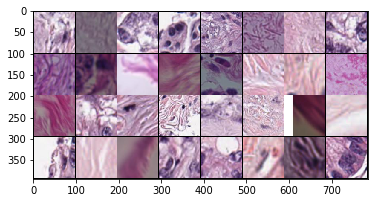

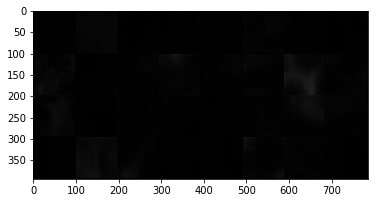

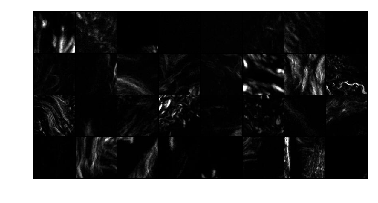

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


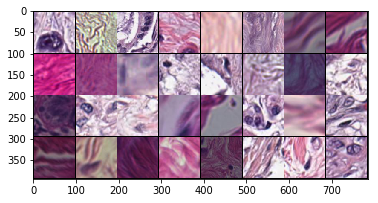

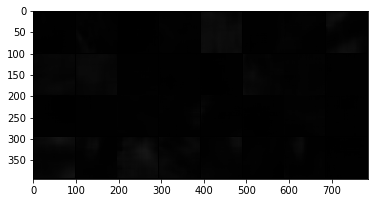

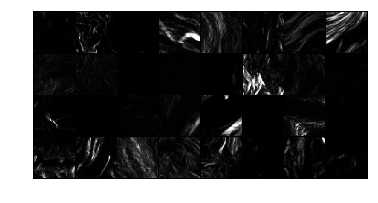

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


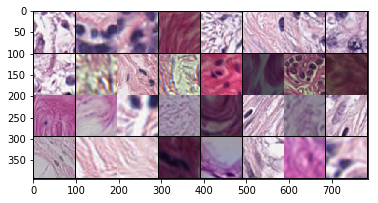

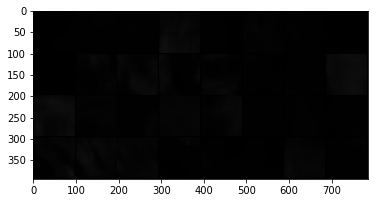

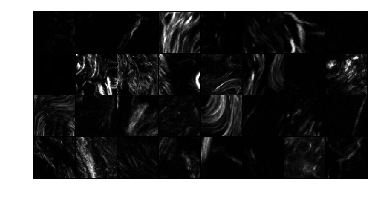

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


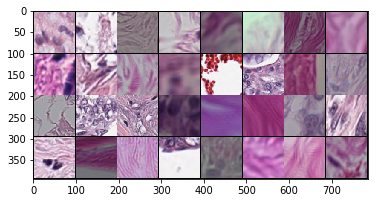

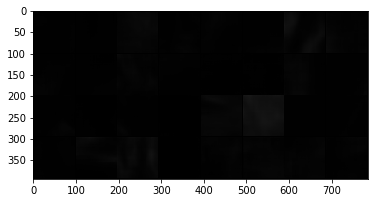

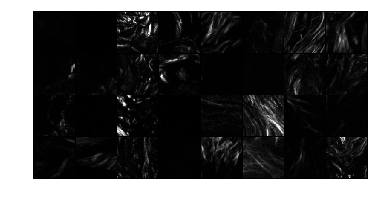

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


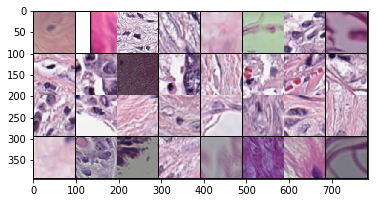

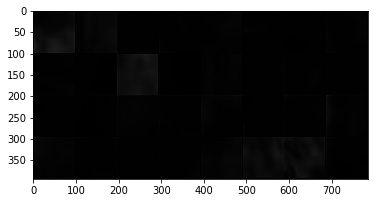

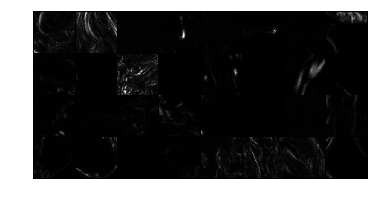

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


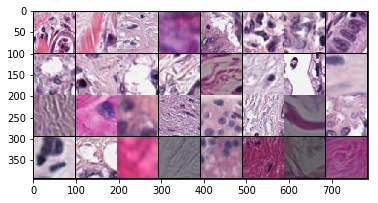

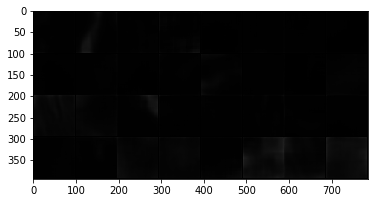

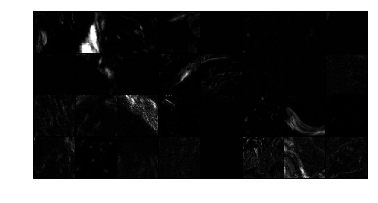

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


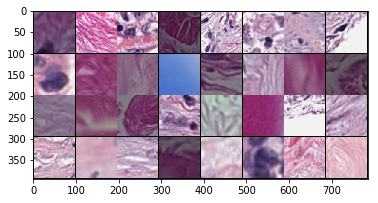

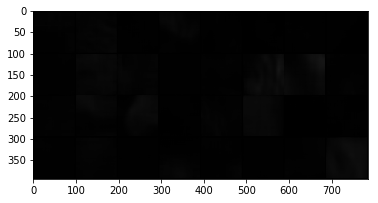

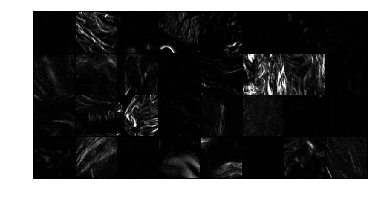

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


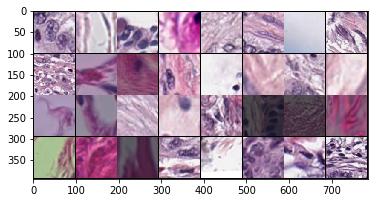

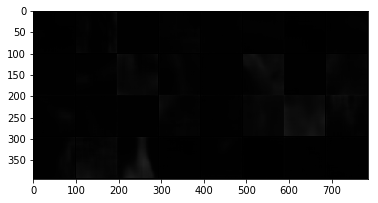

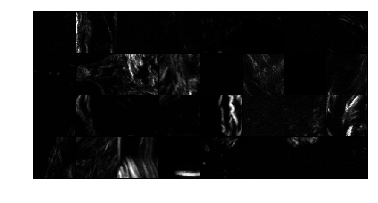

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


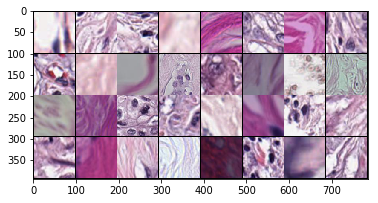

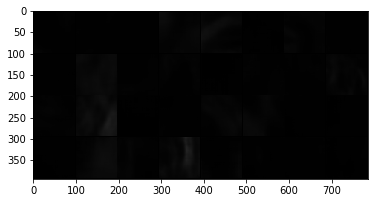

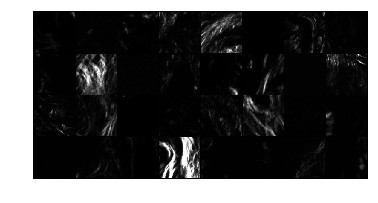

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


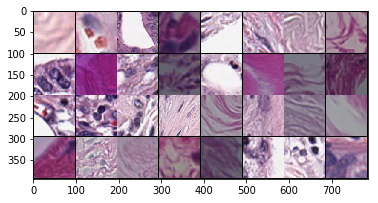

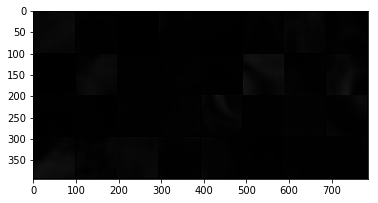

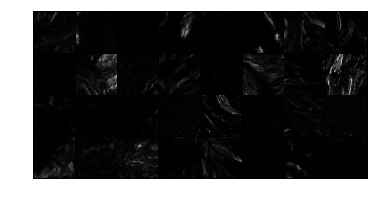

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


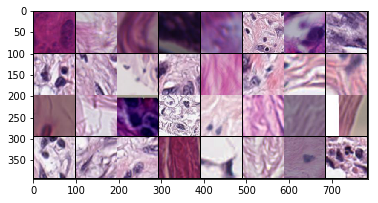

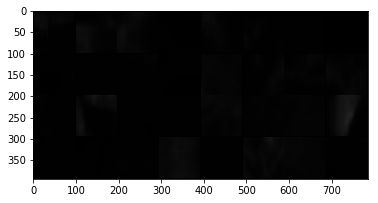

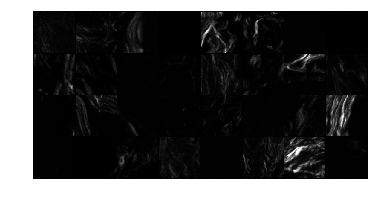

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


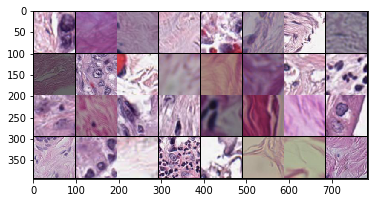

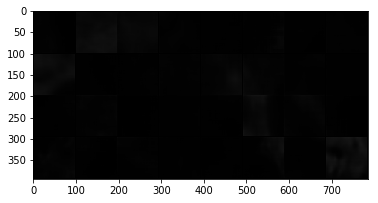

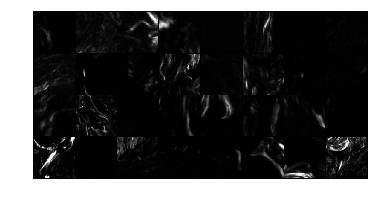

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


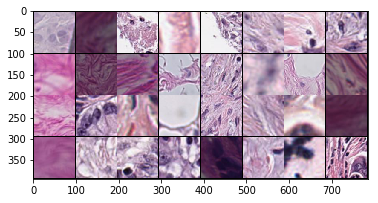

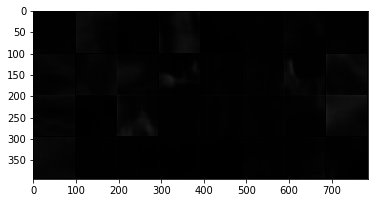

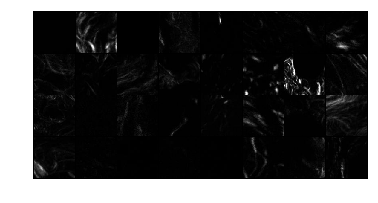

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


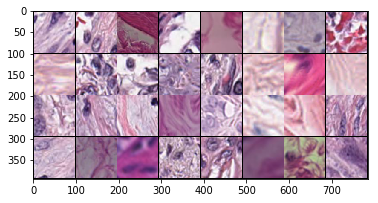

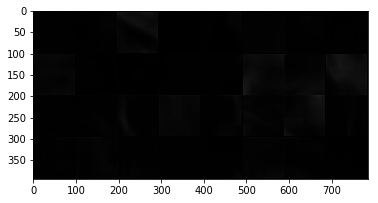

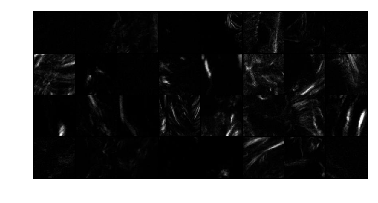

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


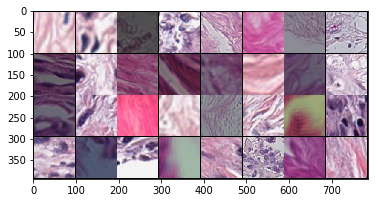

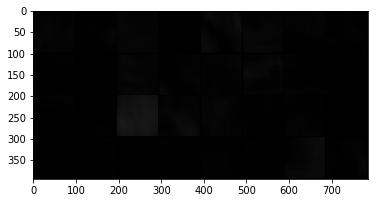

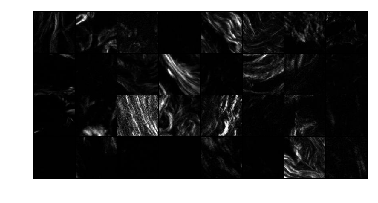

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


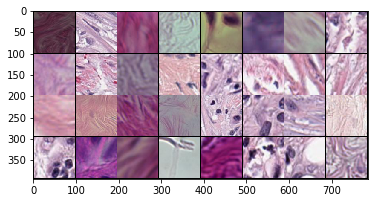

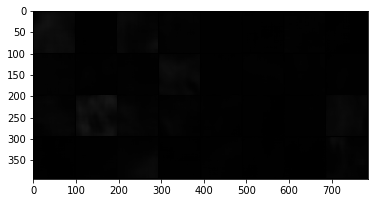

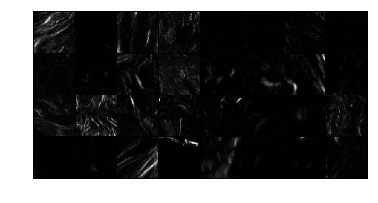

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


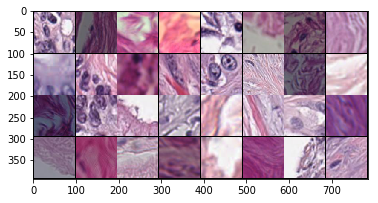

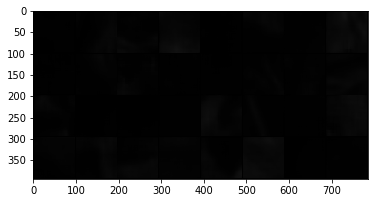

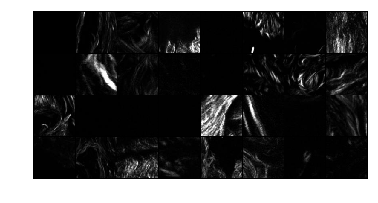

===> Avg. PSNR: nan dB


In [45]:
test()

In [ ]:
l = 0.001
p = 0.5
windowsize = 4
for epoch in range(1, 18 + 1):
    if epoch%2 == 0:
        windowsize = windowsize+1
        p = p*0.8
        l = l*0.2
        if windowsize == 0:
            windowsze = 1
    optimizer = optim.Adam(model.parameters(), lr=l)
        
    train(epoch, p, windowsize)

lossMSE: 0.003864143043756485 lossSSIM: 0.22081106901168823
===> Epoch[1](0/25343): Loss: 0.1123
lossMSE: 0.009324544109404087 lossSSIM: 0.25245726108551025
===> Epoch[1](50/25343): Loss: 0.1309
lossMSE: 0.0017637461423873901 lossSSIM: 0.22006702423095703
===> Epoch[1](100/25343): Loss: 0.1109
lossMSE: 0.007370453793555498 lossSSIM: 0.25450003147125244
===> Epoch[1](150/25343): Loss: 0.1309
lossMSE: 0.00791291892528534 lossSSIM: 0.2180262804031372
===> Epoch[1](200/25343): Loss: 0.1130
lossMSE: 0.008001468144357204 lossSSIM: 0.24663305282592773
===> Epoch[1](250/25343): Loss: 0.1273
lossMSE: 0.005837003234773874 lossSSIM: 0.2741621732711792
===> Epoch[1](300/25343): Loss: 0.1400
lossMSE: 0.00781435426324606 lossSSIM: 0.24249249696731567
===> Epoch[1](350/25343): Loss: 0.1252
lossMSE: 0.005495252553373575 lossSSIM: 0.27066922187805176
===> Epoch[1](400/25343): Loss: 0.1381
lossMSE: 0.004389241803437471 lossSSIM: 0.242567777633667
===> Epoch[1](450/25343): Loss: 0.1235
lossMSE: 0.0061593

lossMSE: 0.007680365815758705 lossSSIM: 0.2793436646461487
===> Epoch[1](4150/25343): Loss: 0.1435
lossMSE: 0.0036677089519798756 lossSSIM: 0.21983754634857178
===> Epoch[1](4200/25343): Loss: 0.1118
lossMSE: 0.0061903586611151695 lossSSIM: 0.2821013927459717
===> Epoch[1](4250/25343): Loss: 0.1441
lossMSE: 0.00745006836950779 lossSSIM: 0.2737974524497986
===> Epoch[1](4300/25343): Loss: 0.1406
lossMSE: 0.005272026639431715 lossSSIM: 0.24298405647277832
===> Epoch[1](4350/25343): Loss: 0.1241
lossMSE: 0.0021259584464132786 lossSSIM: 0.18567538261413574
===> Epoch[1](4400/25343): Loss: 0.0939
lossMSE: 0.005051068030297756 lossSSIM: 0.1973699927330017
===> Epoch[1](4450/25343): Loss: 0.1012
lossMSE: 0.003710601944476366 lossSSIM: 0.2289520502090454
===> Epoch[1](4500/25343): Loss: 0.1163
lossMSE: 0.00519863935187459 lossSSIM: 0.27675431966781616
===> Epoch[1](4550/25343): Loss: 0.1410
lossMSE: 0.012836804613471031 lossSSIM: 0.2311544418334961
===> Epoch[1](4600/25343): Loss: 0.1220
lossM

lossMSE: 0.0018105001654475927 lossSSIM: 0.20447319746017456
===> Epoch[1](8300/25343): Loss: 0.1031
lossMSE: 0.0073335543274879456 lossSSIM: 0.2628737688064575
===> Epoch[1](8350/25343): Loss: 0.1351
lossMSE: 0.0038951693568378687 lossSSIM: 0.24088197946548462
===> Epoch[1](8400/25343): Loss: 0.1224
lossMSE: 0.00487572280690074 lossSSIM: 0.18781054019927979
===> Epoch[1](8450/25343): Loss: 0.0963
lossMSE: 0.0052693733014166355 lossSSIM: 0.23269355297088623
===> Epoch[1](8500/25343): Loss: 0.1190
lossMSE: 0.004094815347343683 lossSSIM: 0.2132301926612854
===> Epoch[1](8550/25343): Loss: 0.1087
lossMSE: 0.009060677140951157 lossSSIM: 0.24839073419570923
===> Epoch[1](8600/25343): Loss: 0.1287
lossMSE: 0.003990977071225643 lossSSIM: 0.23068535327911377
===> Epoch[1](8650/25343): Loss: 0.1173
lossMSE: 0.0034247685689479113 lossSSIM: 0.23694384098052979
===> Epoch[1](8700/25343): Loss: 0.1202
lossMSE: 0.0069570294581353664 lossSSIM: 0.2916356921195984
===> Epoch[1](8750/25343): Loss: 0.149

lossMSE: 0.0054781255312263966 lossSSIM: 0.2619117498397827
===> Epoch[1](12400/25343): Loss: 0.1337
lossMSE: 0.005531415343284607 lossSSIM: 0.22054153680801392
===> Epoch[1](12450/25343): Loss: 0.1130
lossMSE: 0.005523571744561195 lossSSIM: 0.23848676681518555
===> Epoch[1](12500/25343): Loss: 0.1220
lossMSE: 0.008955308236181736 lossSSIM: 0.23621559143066406
===> Epoch[1](12550/25343): Loss: 0.1226
lossMSE: 0.007484303787350655 lossSSIM: 0.23286515474319458
===> Epoch[1](12600/25343): Loss: 0.1202
lossMSE: 0.004774780478328466 lossSSIM: 0.19989913702011108
===> Epoch[1](12650/25343): Loss: 0.1023
lossMSE: 0.01009539794176817 lossSSIM: 0.28771865367889404
===> Epoch[1](12700/25343): Loss: 0.1489
lossMSE: 0.006410301197320223 lossSSIM: 0.24081045389175415
===> Epoch[1](12750/25343): Loss: 0.1236
lossMSE: 0.010970916599035263 lossSSIM: 0.2716206908226013
===> Epoch[1](12800/25343): Loss: 0.1413
lossMSE: 0.010329733602702618 lossSSIM: 0.2542514204978943
===> Epoch[1](12850/25343): Loss: 

lossMSE: 0.004249542485922575 lossSSIM: 0.25031232833862305
===> Epoch[1](16500/25343): Loss: 0.1273
lossMSE: 0.005402297712862492 lossSSIM: 0.22957229614257812
===> Epoch[1](16550/25343): Loss: 0.1175
lossMSE: 0.008181232959032059 lossSSIM: 0.23669564723968506
===> Epoch[1](16600/25343): Loss: 0.1224
lossMSE: 0.002721088007092476 lossSSIM: 0.1901611089706421
===> Epoch[1](16650/25343): Loss: 0.0964
lossMSE: 0.006487350445240736 lossSSIM: 0.25160717964172363
===> Epoch[1](16700/25343): Loss: 0.1290
lossMSE: 0.011244469322264194 lossSSIM: 0.2850103974342346
===> Epoch[1](16750/25343): Loss: 0.1481
lossMSE: 0.006457647308707237 lossSSIM: 0.2705584168434143
===> Epoch[1](16800/25343): Loss: 0.1385
lossMSE: 0.0038027067203074694 lossSSIM: 0.19992130994796753
===> Epoch[1](16850/25343): Loss: 0.1019
lossMSE: 0.007501370273530483 lossSSIM: 0.2668837308883667
===> Epoch[1](16900/25343): Loss: 0.1372
lossMSE: 0.004989546723663807 lossSSIM: 0.2467380166053772
===> Epoch[1](16950/25343): Loss: 0

lossMSE: 0.00939240027219057 lossSSIM: 0.26138871908187866
===> Epoch[1](20600/25343): Loss: 0.1354
lossMSE: 0.008895806036889553 lossSSIM: 0.2984102964401245
===> Epoch[1](20650/25343): Loss: 0.1537
lossMSE: 0.006796237546950579 lossSSIM: 0.27272695302963257
===> Epoch[1](20700/25343): Loss: 0.1398
lossMSE: 0.002451061038300395 lossSSIM: 0.22128349542617798
===> Epoch[1](20750/25343): Loss: 0.1119
lossMSE: 0.006195714697241783 lossSSIM: 0.20810776948928833
===> Epoch[1](20800/25343): Loss: 0.1072
lossMSE: 0.007922296412289143 lossSSIM: 0.2692720293998718
===> Epoch[1](20850/25343): Loss: 0.1386
lossMSE: 0.005063893273472786 lossSSIM: 0.24041622877120972
===> Epoch[1](20900/25343): Loss: 0.1227
lossMSE: 0.008457300253212452 lossSSIM: 0.26454877853393555
===> Epoch[1](20950/25343): Loss: 0.1365
lossMSE: 0.006591509561985731 lossSSIM: 0.23031657934188843
===> Epoch[1](21000/25343): Loss: 0.1185
lossMSE: 0.0031932645943015814 lossSSIM: 0.22985941171646118
===> Epoch[1](21050/25343): Loss:

lossMSE: 0.008325300179421902 lossSSIM: 0.25536972284317017
===> Epoch[1](24700/25343): Loss: 0.1318
lossMSE: 0.005869677755981684 lossSSIM: 0.2545582056045532
===> Epoch[1](24750/25343): Loss: 0.1302
lossMSE: 0.005670159589499235 lossSSIM: 0.24370157718658447
===> Epoch[1](24800/25343): Loss: 0.1247
lossMSE: 0.006418243981897831 lossSSIM: 0.266910195350647
===> Epoch[1](24850/25343): Loss: 0.1367
lossMSE: 0.00504756486043334 lossSSIM: 0.2562491297721863
===> Epoch[1](24900/25343): Loss: 0.1306
lossMSE: 0.0028827690985053778 lossSSIM: 0.1833338737487793
===> Epoch[1](24950/25343): Loss: 0.0931
lossMSE: 0.004846334457397461 lossSSIM: 0.23461222648620605
===> Epoch[1](25000/25343): Loss: 0.1197
lossMSE: 0.008667413145303726 lossSSIM: 0.2817125916481018
===> Epoch[1](25050/25343): Loss: 0.1452
lossMSE: 0.0036663785576820374 lossSSIM: 0.22379618883132935
===> Epoch[1](25100/25343): Loss: 0.1137
lossMSE: 0.006794178858399391 lossSSIM: 0.28517991304397583
===> Epoch[1](25150/25343): Loss: 0.

lossMSE: 0.0043914723210036755 lossSSIM: 0.21108287572860718
===> Epoch[2](3450/25343): Loss: 0.1284
lossMSE: 0.0076470873318612576 lossSSIM: 0.25000476837158203
===> Epoch[2](3500/25343): Loss: 0.1531
lossMSE: 0.004761362913995981 lossSSIM: 0.2524319291114807
===> Epoch[2](3550/25343): Loss: 0.1534
lossMSE: 0.001943579176440835 lossSSIM: 0.17981529235839844
===> Epoch[2](3600/25343): Loss: 0.1087
lossMSE: 0.011569923721253872 lossSSIM: 0.27499914169311523
===> Epoch[2](3650/25343): Loss: 0.1696
lossMSE: 0.009995424188673496 lossSSIM: 0.2508118748664856
===> Epoch[2](3700/25343): Loss: 0.1545
lossMSE: 0.011044942773878574 lossSSIM: 0.3392777442932129
===> Epoch[2](3750/25343): Loss: 0.2080
lossMSE: 0.0023010040167719126 lossSSIM: 0.21014612913131714
===> Epoch[2](3800/25343): Loss: 0.1270
lossMSE: 0.00288914842531085 lossSSIM: 0.20543575286865234
===> Epoch[2](3850/25343): Loss: 0.1244
lossMSE: 0.0035426882095634937 lossSSIM: 0.2398676872253418
===> Epoch[2](3900/25343): Loss: 0.1453
l

lossMSE: 0.0069310227409005165 lossSSIM: 0.27012091875076294
===> Epoch[2](7600/25343): Loss: 0.1648
lossMSE: 0.0032865533139556646 lossSSIM: 0.22038674354553223
===> Epoch[2](7650/25343): Loss: 0.1335
lossMSE: 0.005476426798850298 lossSSIM: 0.25115638971328735
===> Epoch[2](7700/25343): Loss: 0.1529
lossMSE: 0.004372652154415846 lossSSIM: 0.25501227378845215
===> Epoch[2](7750/25343): Loss: 0.1548
lossMSE: 0.004715798422694206 lossSSIM: 0.22372221946716309
===> Epoch[2](7800/25343): Loss: 0.1361
lossMSE: 0.004110939800739288 lossSSIM: 0.2758646011352539
===> Epoch[2](7850/25343): Loss: 0.1672
lossMSE: 0.005622616969048977 lossSSIM: 0.25930237770080566
===> Epoch[2](7900/25343): Loss: 0.1578
lossMSE: 0.003965540789067745 lossSSIM: 0.25130218267440796
===> Epoch[2](7950/25343): Loss: 0.1524
lossMSE: 0.0027917271945625544 lossSSIM: 0.23335766792297363
===> Epoch[2](8000/25343): Loss: 0.1411
lossMSE: 0.006295390427112579 lossSSIM: 0.3009624481201172
===> Epoch[2](8050/25343): Loss: 0.1831

lossMSE: 0.00281409895978868 lossSSIM: 0.21212983131408691
===> Epoch[2](11700/25343): Loss: 0.1284
lossMSE: 0.006365228909999132 lossSSIM: 0.2731192111968994
===> Epoch[2](11750/25343): Loss: 0.1664
lossMSE: 0.007126468699425459 lossSSIM: 0.2600657343864441
===> Epoch[2](11800/25343): Loss: 0.1589
lossMSE: 0.004617149010300636 lossSSIM: 0.23447227478027344
===> Epoch[2](11850/25343): Loss: 0.1425
lossMSE: 0.0047265756875276566 lossSSIM: 0.2194594144821167
===> Epoch[2](11900/25343): Loss: 0.1336
lossMSE: 0.005646275356411934 lossSSIM: 0.28361254930496216
===> Epoch[2](11950/25343): Loss: 0.1724
lossMSE: 0.0041588046588003635 lossSSIM: 0.21986234188079834
===> Epoch[2](12000/25343): Loss: 0.1336
lossMSE: 0.005970656871795654 lossSSIM: 0.22779470682144165
===> Epoch[2](12050/25343): Loss: 0.1391
lossMSE: 0.005652505438774824 lossSSIM: 0.2476024031639099
===> Epoch[2](12100/25343): Loss: 0.1508
lossMSE: 0.005857950542122126 lossSSIM: 0.31015563011169434
===> Epoch[2](12150/25343): Loss: 

lossMSE: 0.009789680130779743 lossSSIM: 0.2574959397315979
===> Epoch[2](15800/25343): Loss: 0.1584
lossMSE: 0.01628890633583069 lossSSIM: 0.2693100571632385
===> Epoch[2](15850/25343): Loss: 0.1681
lossMSE: 0.004147363360971212 lossSSIM: 0.2506539821624756
===> Epoch[2](15900/25343): Loss: 0.1521
lossMSE: 0.006813587620854378 lossSSIM: 0.2694981098175049
===> Epoch[2](15950/25343): Loss: 0.1644
lossMSE: 0.006254429463297129 lossSSIM: 0.26278620958328247
===> Epoch[2](16000/25343): Loss: 0.1602
lossMSE: 0.008652453310787678 lossSSIM: 0.21851307153701782
===> Epoch[2](16050/25343): Loss: 0.1346
lossMSE: 0.007368162274360657 lossSSIM: 0.31380248069763184
===> Epoch[2](16100/25343): Loss: 0.1912
lossMSE: 0.003337516915053129 lossSSIM: 0.23459148406982422
===> Epoch[2](16150/25343): Loss: 0.1421
lossMSE: 0.002619753824546933 lossSSIM: 0.2273579239845276
===> Epoch[2](16200/25343): Loss: 0.1375
lossMSE: 0.006238841917365789 lossSSIM: 0.25583136081695557
===> Epoch[2](16250/25343): Loss: 0.1

lossMSE: 0.00858423113822937 lossSSIM: 0.3094223737716675
===> Epoch[2](19900/25343): Loss: 0.1891
lossMSE: 0.007900170050561428 lossSSIM: 0.2631016969680786
===> Epoch[2](19950/25343): Loss: 0.1610
lossMSE: 0.00804481003433466 lossSSIM: 0.24326962232589722
===> Epoch[2](20000/25343): Loss: 0.1492
lossMSE: 0.008700002916157246 lossSSIM: 0.2848661541938782
===> Epoch[2](20050/25343): Loss: 0.1744
lossMSE: 0.0036788578145205975 lossSSIM: 0.24063807725906372
===> Epoch[2](20100/25343): Loss: 0.1459
lossMSE: 0.007387802004814148 lossSSIM: 0.26487672328948975
===> Epoch[2](20150/25343): Loss: 0.1619
lossMSE: 0.002923710737377405 lossSSIM: 0.1953309178352356
===> Epoch[2](20200/25343): Loss: 0.1184
lossMSE: 0.005693070590496063 lossSSIM: 0.2505931854248047
===> Epoch[2](20250/25343): Loss: 0.1526
lossMSE: 0.0031635910272598267 lossSSIM: 0.21250468492507935
===> Epoch[2](20300/25343): Loss: 0.1288
lossMSE: 0.0042406897991895676 lossSSIM: 0.22626054286956787
===> Epoch[2](20350/25343): Loss: 0

lossMSE: 0.005198145285248756 lossSSIM: 0.270469605922699
===> Epoch[2](24000/25343): Loss: 0.1644
lossMSE: 0.010435326024889946 lossSSIM: 0.26428496837615967
===> Epoch[2](24050/25343): Loss: 0.1627
lossMSE: 0.007463352754712105 lossSSIM: 0.2293764352798462
===> Epoch[2](24100/25343): Loss: 0.1406
lossMSE: 0.0070680659264326096 lossSSIM: 0.23461651802062988
===> Epoch[2](24150/25343): Loss: 0.1436
lossMSE: 0.00847606547176838 lossSSIM: 0.30072563886642456
===> Epoch[2](24200/25343): Loss: 0.1838
lossMSE: 0.004906169604510069 lossSSIM: 0.27518028020858765
===> Epoch[2](24250/25343): Loss: 0.1671
lossMSE: 0.00818901788443327 lossSSIM: 0.2549872398376465
===> Epoch[2](24300/25343): Loss: 0.1563
lossMSE: 0.003574034431949258 lossSSIM: 0.24967485666275024
===> Epoch[2](24350/25343): Loss: 0.1512
lossMSE: 0.011842887848615646 lossSSIM: 0.3097591996192932
===> Epoch[2](24400/25343): Loss: 0.1906
lossMSE: 0.005640164017677307 lossSSIM: 0.2906032204627991
===> Epoch[2](24450/25343): Loss: 0.17

lossMSE: 0.0038017937913537025 lossSSIM: 0.26810985803604126
===> Epoch[3](2750/25343): Loss: 0.1624
lossMSE: 0.009627746418118477 lossSSIM: 0.2651975154876709
===> Epoch[3](2800/25343): Loss: 0.1630
lossMSE: 0.009875627234578133 lossSSIM: 0.2744588255882263
===> Epoch[3](2850/25343): Loss: 0.1686
lossMSE: 0.0033655851148068905 lossSSIM: 0.22299915552139282
===> Epoch[3](2900/25343): Loss: 0.1351
lossMSE: 0.0056142620742321014 lossSSIM: 0.21714448928833008
===> Epoch[3](2950/25343): Loss: 0.1325
lossMSE: 0.005285437684506178 lossSSIM: 0.2299044132232666
===> Epoch[3](3000/25343): Loss: 0.1401
lossMSE: 0.005045734345912933 lossSSIM: 0.2203349471092224
===> Epoch[3](3050/25343): Loss: 0.1342
lossMSE: 0.011316942982375622 lossSSIM: 0.2911913990974426
===> Epoch[3](3100/25343): Loss: 0.1792
lossMSE: 0.0052150581032037735 lossSSIM: 0.2663450837135315
===> Epoch[3](3150/25343): Loss: 0.1619
lossMSE: 0.004082200583070517 lossSSIM: 0.242972731590271
===> Epoch[3](3200/25343): Loss: 0.1474
loss

lossMSE: 0.006909763440489769 lossSSIM: 0.28561151027679443
===> Epoch[3](6900/25343): Loss: 0.1741
lossMSE: 0.006752975285053253 lossSSIM: 0.2677687406539917
===> Epoch[3](6950/25343): Loss: 0.1634
lossMSE: 0.00624387152493 lossSSIM: 0.26982277631759644
===> Epoch[3](7000/25343): Loss: 0.1644
lossMSE: 0.004993992391973734 lossSSIM: 0.24037158489227295
===> Epoch[3](7050/25343): Loss: 0.1462
lossMSE: 0.010843907482922077 lossSSIM: 0.25957316160202026
===> Epoch[3](7100/25343): Loss: 0.1601
lossMSE: 0.01071355864405632 lossSSIM: 0.22985517978668213
===> Epoch[3](7150/25343): Loss: 0.1422
lossMSE: 0.005300197750329971 lossSSIM: 0.2916887402534485
===> Epoch[3](7200/25343): Loss: 0.1771
lossMSE: 0.009014020673930645 lossSSIM: 0.2418825626373291
===> Epoch[3](7250/25343): Loss: 0.1487
lossMSE: 0.011399637907743454 lossSSIM: 0.2689095735549927
===> Epoch[3](7300/25343): Loss: 0.1659
lossMSE: 0.0026852514129132032 lossSSIM: 0.20598763227462769
===> Epoch[3](7350/25343): Loss: 0.1247
lossMSE:

lossMSE: 0.0059389397501945496 lossSSIM: 0.26840853691101074
===> Epoch[3](11050/25343): Loss: 0.1634
lossMSE: 0.0061076791025698185 lossSSIM: 0.2515518069267273
===> Epoch[3](11100/25343): Loss: 0.1534
lossMSE: 0.007782196160405874 lossSSIM: 0.26738715171813965
===> Epoch[3](11150/25343): Loss: 0.1635
lossMSE: 0.007146946154534817 lossSSIM: 0.21337974071502686
===> Epoch[3](11200/25343): Loss: 0.1309
lossMSE: 0.004002819303423166 lossSSIM: 0.21409422159194946
===> Epoch[3](11250/25343): Loss: 0.1301
lossMSE: 0.010903739370405674 lossSSIM: 0.2433876395225525
===> Epoch[3](11300/25343): Loss: 0.1504
lossMSE: 0.00603015162050724 lossSSIM: 0.2378215789794922
===> Epoch[3](11350/25343): Loss: 0.1451
lossMSE: 0.0045078108087182045 lossSSIM: 0.25197523832321167
===> Epoch[3](11400/25343): Loss: 0.1530
lossMSE: 0.005145873408764601 lossSSIM: 0.28229743242263794
===> Epoch[3](11450/25343): Loss: 0.1714
lossMSE: 0.006098669953644276 lossSSIM: 0.22016984224319458
===> Epoch[3](11500/25343): Loss

lossMSE: 0.003919621929526329 lossSSIM: 0.23866164684295654
===> Epoch[3](15150/25343): Loss: 0.1448
lossMSE: 0.004817529581487179 lossSSIM: 0.21883785724639893
===> Epoch[3](15200/25343): Loss: 0.1332
lossMSE: 0.0031712516210973263 lossSSIM: 0.23197782039642334
===> Epoch[3](15250/25343): Loss: 0.1405
lossMSE: 0.01153864711523056 lossSSIM: 0.32979637384414673
===> Epoch[3](15300/25343): Loss: 0.2025
lossMSE: 0.007945973426103592 lossSSIM: 0.23959112167358398
===> Epoch[3](15350/25343): Loss: 0.1469
lossMSE: 0.0056762974709272385 lossSSIM: 0.2707369327545166
===> Epoch[3](15400/25343): Loss: 0.1647
lossMSE: 0.004239130299538374 lossSSIM: 0.23416417837142944
===> Epoch[3](15450/25343): Loss: 0.1422
lossMSE: 0.007496161386370659 lossSSIM: 0.27352404594421387
===> Epoch[3](15500/25343): Loss: 0.1671
lossMSE: 0.004517631605267525 lossSSIM: 0.258140504360199
===> Epoch[3](15550/25343): Loss: 0.1567
lossMSE: 0.006017459090799093 lossSSIM: 0.2578911781311035
===> Epoch[3](15600/25343): Loss: 

lossMSE: 0.010595436207950115 lossSSIM: 0.20291566848754883
===> Epoch[3](19250/25343): Loss: 0.1260
lossMSE: 0.005293572321534157 lossSSIM: 0.2537873387336731
===> Epoch[3](19300/25343): Loss: 0.1544
lossMSE: 0.002135208109393716 lossSSIM: 0.22924816608428955
===> Epoch[3](19350/25343): Loss: 0.1384
lossMSE: 0.004773755092173815 lossSSIM: 0.23248010873794556
===> Epoch[3](19400/25343): Loss: 0.1414
lossMSE: 0.0027969726361334324 lossSSIM: 0.20627206563949585
===> Epoch[3](19450/25343): Loss: 0.1249
lossMSE: 0.006064323708415031 lossSSIM: 0.2694582939147949
===> Epoch[3](19500/25343): Loss: 0.1641
lossMSE: 0.0047954474575817585 lossSSIM: 0.24834084510803223
===> Epoch[3](19550/25343): Loss: 0.1509
lossMSE: 0.008739362470805645 lossSSIM: 0.2571052312850952
===> Epoch[3](19600/25343): Loss: 0.1578
lossMSE: 0.0040307859890162945 lossSSIM: 0.23220103979110718
===> Epoch[3](19650/25343): Loss: 0.1409
lossMSE: 0.0031830263324081898 lossSSIM: 0.2192043662071228
===> Epoch[3](19700/25343): Los

lossMSE: 0.009360053576529026 lossSSIM: 0.30760663747787476
===> Epoch[3](23350/25343): Loss: 0.1883
lossMSE: 0.010652903467416763 lossSSIM: 0.2741609215736389
===> Epoch[3](23400/25343): Loss: 0.1688
lossMSE: 0.0046232230961322784 lossSSIM: 0.22899556159973145
===> Epoch[3](23450/25343): Loss: 0.1392
lossMSE: 0.0032863186206668615 lossSSIM: 0.2546617388725281
===> Epoch[3](23500/25343): Loss: 0.1541
lossMSE: 0.003709046868607402 lossSSIM: 0.22520506381988525
===> Epoch[3](23550/25343): Loss: 0.1366
lossMSE: 0.002979774959385395 lossSSIM: 0.20061320066452026
===> Epoch[3](23600/25343): Loss: 0.1216
lossMSE: 0.003154830075800419 lossSSIM: 0.2267095446586609
===> Epoch[3](23650/25343): Loss: 0.1373
lossMSE: 0.00996498391032219 lossSSIM: 0.271354079246521
===> Epoch[3](23700/25343): Loss: 0.1668
lossMSE: 0.005504499655216932 lossSSIM: 0.2598229646682739
===> Epoch[3](23750/25343): Loss: 0.1581
lossMSE: 0.002261699875816703 lossSSIM: 0.24211758375167847
===> Epoch[3](23800/25343): Loss: 0.

lossMSE: 0.0069835493341088295 lossSSIM: 0.21457171440124512
===> Epoch[4](2100/25343): Loss: 0.1481
lossMSE: 0.010230515152215958 lossSSIM: 0.33095884323120117
===> Epoch[4](2150/25343): Loss: 0.2283
lossMSE: 0.0047118752263486385 lossSSIM: 0.24978065490722656
===> Epoch[4](2200/25343): Loss: 0.1714
lossMSE: 0.004951408598572016 lossSSIM: 0.2717079520225525
===> Epoch[4](2250/25343): Loss: 0.1863
lossMSE: 0.005795738194137812 lossSSIM: 0.28273212909698486
===> Epoch[4](2300/25343): Loss: 0.1941
lossMSE: 0.0038616773672401905 lossSSIM: 0.2533096671104431
===> Epoch[4](2350/25343): Loss: 0.1735
lossMSE: 0.005747201386839151 lossSSIM: 0.2747384309768677
===> Epoch[4](2400/25343): Loss: 0.1887
lossMSE: 0.004273666068911552 lossSSIM: 0.25171488523483276
===> Epoch[4](2450/25343): Loss: 0.1725
lossMSE: 0.009431562386453152 lossSSIM: 0.255371630191803
===> Epoch[4](2500/25343): Loss: 0.1767
lossMSE: 0.0030989244114607573 lossSSIM: 0.22069239616394043
===> Epoch[4](2550/25343): Loss: 0.1511
l

lossMSE: 0.005785567685961723 lossSSIM: 0.23428255319595337
===> Epoch[4](6250/25343): Loss: 0.1612
lossMSE: 0.006086272187530994 lossSSIM: 0.2714207172393799
===> Epoch[4](6300/25343): Loss: 0.1865
lossMSE: 0.0034815031103789806 lossSSIM: 0.21672803163528442
===> Epoch[4](6350/25343): Loss: 0.1485
lossMSE: 0.005559081677347422 lossSSIM: 0.24504679441452026
===> Epoch[4](6400/25343): Loss: 0.1684
lossMSE: 0.008067437447607517 lossSSIM: 0.2948501706123352
===> Epoch[4](6450/25343): Loss: 0.2031
lossMSE: 0.007024706341326237 lossSSIM: 0.2562282085418701
===> Epoch[4](6500/25343): Loss: 0.1765
lossMSE: 0.008112410083413124 lossSSIM: 0.2690196633338928
===> Epoch[4](6550/25343): Loss: 0.1855
lossMSE: 0.0071647134609520435 lossSSIM: 0.25897276401519775
===> Epoch[4](6600/25343): Loss: 0.1784
lossMSE: 0.008421757258474827 lossSSIM: 0.29818761348724365
===> Epoch[4](6650/25343): Loss: 0.2055
lossMSE: 0.00608869967982173 lossSSIM: 0.23790401220321655
===> Epoch[4](6700/25343): Loss: 0.1637
los

lossMSE: 0.007607231382280588 lossSSIM: 0.27005404233932495
===> Epoch[4](10400/25343): Loss: 0.1861
lossMSE: 0.010530222207307816 lossSSIM: 0.3598676919937134
===> Epoch[4](10450/25343): Loss: 0.2481
lossMSE: 0.007275907322764397 lossSSIM: 0.27591896057128906
===> Epoch[4](10500/25343): Loss: 0.1900
lossMSE: 0.0048198155127465725 lossSSIM: 0.2241995930671692
===> Epoch[4](10550/25343): Loss: 0.1540
lossMSE: 0.003708025673404336 lossSSIM: 0.24713248014450073
===> Epoch[4](10600/25343): Loss: 0.1692
lossMSE: 0.006434653420001268 lossSSIM: 0.26427823305130005
===> Epoch[4](10650/25343): Loss: 0.1818
lossMSE: 0.0066925957798957825 lossSSIM: 0.22734355926513672
===> Epoch[4](10700/25343): Loss: 0.1567
lossMSE: 0.007952258922159672 lossSSIM: 0.2659858465194702
===> Epoch[4](10750/25343): Loss: 0.1834
lossMSE: 0.0042098951525986195 lossSSIM: 0.23603981733322144
===> Epoch[4](10800/25343): Loss: 0.1619
lossMSE: 0.004240710753947496 lossSSIM: 0.20616209506988525
===> Epoch[4](10850/25343): Los

lossMSE: 0.0038832323625683784 lossSSIM: 0.23430657386779785
===> Epoch[4](14500/25343): Loss: 0.1606
lossMSE: 0.0026722638867795467 lossSSIM: 0.2087949514389038
===> Epoch[4](14550/25343): Loss: 0.1428
lossMSE: 0.008905087597668171 lossSSIM: 0.3022781014442444
===> Epoch[4](14600/25343): Loss: 0.2084
lossMSE: 0.025435246527194977 lossSSIM: 0.27665597200393677
===> Epoch[4](14650/25343): Loss: 0.1963
lossMSE: 0.003192642005160451 lossSSIM: 0.2169342041015625
===> Epoch[4](14700/25343): Loss: 0.1485
lossMSE: 0.005208743270486593 lossSSIM: 0.24019038677215576
===> Epoch[4](14750/25343): Loss: 0.1650
lossMSE: 0.006212638691067696 lossSSIM: 0.2863280773162842
===> Epoch[4](14800/25343): Loss: 0.1967
lossMSE: 0.004551561549305916 lossSSIM: 0.24820160865783691
===> Epoch[4](14850/25343): Loss: 0.1702
lossMSE: 0.0036811567842960358 lossSSIM: 0.24921852350234985
===> Epoch[4](14900/25343): Loss: 0.1706
lossMSE: 0.0034244295675307512 lossSSIM: 0.2333996295928955
===> Epoch[4](14950/25343): Loss

lossMSE: 0.009256475605070591 lossSSIM: 0.2557855248451233
===> Epoch[4](18600/25343): Loss: 0.1769
lossMSE: 0.011728606186807156 lossSSIM: 0.2897565960884094
===> Epoch[4](18650/25343): Loss: 0.2008
lossMSE: 0.0040712738409638405 lossSSIM: 0.2407536506652832
===> Epoch[4](18700/25343): Loss: 0.1650
lossMSE: 0.004552064463496208 lossSSIM: 0.29249107837677
===> Epoch[4](18750/25343): Loss: 0.2004
lossMSE: 0.00762997567653656 lossSSIM: 0.26241737604141235
===> Epoch[4](18800/25343): Loss: 0.1809
lossMSE: 0.010874518193304539 lossSSIM: 0.2789049744606018
===> Epoch[4](18850/25343): Loss: 0.1931
lossMSE: 0.01716381311416626 lossSSIM: 0.298362672328949
===> Epoch[4](18900/25343): Loss: 0.2084
lossMSE: 0.003493697615340352 lossSSIM: 0.2783302068710327
===> Epoch[4](18950/25343): Loss: 0.1904
lossMSE: 0.002913477597758174 lossSSIM: 0.20386040210723877
===> Epoch[4](19000/25343): Loss: 0.1396
lossMSE: 0.00988968089222908 lossSSIM: 0.34791064262390137
===> Epoch[4](19050/25343): Loss: 0.2397
lo

lossMSE: 0.0031581090297549963 lossSSIM: 0.2131028175354004
===> Epoch[4](22700/25343): Loss: 0.1459
lossMSE: 0.006586868781596422 lossSSIM: 0.262498676776886
===> Epoch[4](22750/25343): Loss: 0.1806
lossMSE: 0.009993994608521461 lossSSIM: 0.278564989566803
===> Epoch[4](22800/25343): Loss: 0.1926
lossMSE: 0.003268283326178789 lossSSIM: 0.2373577356338501
===> Epoch[4](22850/25343): Loss: 0.1624
lossMSE: 0.0057279570028185844 lossSSIM: 0.2607225179672241
===> Epoch[4](22900/25343): Loss: 0.1791
lossMSE: 0.008982458151876926 lossSSIM: 0.29221123456954956
===> Epoch[4](22950/25343): Loss: 0.2016
lossMSE: 0.0070747327990829945 lossSSIM: 0.25687241554260254
===> Epoch[4](23000/25343): Loss: 0.1769
lossMSE: 0.007953794673085213 lossSSIM: 0.3508334755897522
===> Epoch[4](23050/25343): Loss: 0.2411
lossMSE: 0.007969090715050697 lossSSIM: 0.2603331208229065
===> Epoch[4](23100/25343): Loss: 0.1796
lossMSE: 0.004893352743238211 lossSSIM: 0.20998108386993408
===> Epoch[4](23150/25343): Loss: 0.1

lossMSE: 0.0032865286339074373 lossSSIM: 0.20446807146072388
===> Epoch[5](1450/25343): Loss: 0.1401
lossMSE: 0.005217080935835838 lossSSIM: 0.26281434297561646
===> Epoch[5](1500/25343): Loss: 0.1804
lossMSE: 0.002482653595507145 lossSSIM: 0.24283164739608765
===> Epoch[5](1550/25343): Loss: 0.1659
lossMSE: 0.005652455613017082 lossSSIM: 0.27313774824142456
===> Epoch[5](1600/25343): Loss: 0.1875
lossMSE: 0.0127313993871212 lossSSIM: 0.32563459873199463
===> Epoch[5](1650/25343): Loss: 0.2255
lossMSE: 0.004958875477313995 lossSSIM: 0.29074639081954956
===> Epoch[5](1700/25343): Loss: 0.1993
lossMSE: 0.005796073470264673 lossSSIM: 0.2594468593597412
===> Epoch[5](1750/25343): Loss: 0.1783
lossMSE: 0.002244680654257536 lossSSIM: 0.19338804483413696
===> Epoch[5](1800/25343): Loss: 0.1322
lossMSE: 0.008215440437197685 lossSSIM: 0.3043828010559082
===> Epoch[5](1850/25343): Loss: 0.2096
lossMSE: 0.007855248637497425 lossSSIM: 0.24141597747802734
===> Epoch[5](1900/25343): Loss: 0.1667
los

lossMSE: 0.006629291456192732 lossSSIM: 0.2724072337150574
===> Epoch[5](5600/25343): Loss: 0.1874
lossMSE: 0.008529468439519405 lossSSIM: 0.2613752484321594
===> Epoch[5](5650/25343): Loss: 0.1805
lossMSE: 0.0021585794165730476 lossSSIM: 0.20363163948059082
===> Epoch[5](5700/25343): Loss: 0.1392
lossMSE: 0.011296280659735203 lossSSIM: 0.2761174440383911
===> Epoch[5](5750/25343): Loss: 0.1914
lossMSE: 0.012374382466077805 lossSSIM: 0.30071860551834106
===> Epoch[5](5800/25343): Loss: 0.2084
lossMSE: 0.007250281050801277 lossSSIM: 0.26044124364852905
===> Epoch[5](5850/25343): Loss: 0.1794
lossMSE: 0.010527542792260647 lossSSIM: 0.3055860996246338
===> Epoch[5](5900/25343): Loss: 0.2112
lossMSE: 0.008131995797157288 lossSSIM: 0.2680354714393616
===> Epoch[5](5950/25343): Loss: 0.1849
lossMSE: 0.01003857422620058 lossSSIM: 0.26331835985183716
===> Epoch[5](6000/25343): Loss: 0.1823
lossMSE: 0.0076734889298677444 lossSSIM: 0.2475297451019287
===> Epoch[5](6050/25343): Loss: 0.1708
lossM

lossMSE: 0.008871469646692276 lossSSIM: 0.28675323724746704
===> Epoch[5](9750/25343): Loss: 0.1978
lossMSE: 0.011193600483238697 lossSSIM: 0.30432772636413574
===> Epoch[5](9800/25343): Loss: 0.2105
lossMSE: 0.004835804924368858 lossSSIM: 0.23511749505996704
===> Epoch[5](9850/25343): Loss: 0.1614
lossMSE: 0.005427738651633263 lossSSIM: 0.25282835960388184
===> Epoch[5](9900/25343): Loss: 0.1737
lossMSE: 0.008452879264950752 lossSSIM: 0.3231031894683838
===> Epoch[5](9950/25343): Loss: 0.2224
lossMSE: 0.007271650712937117 lossSSIM: 0.27832287549972534
===> Epoch[5](10000/25343): Loss: 0.1916
lossMSE: 0.013808680698275566 lossSSIM: 0.38672345876693726
===> Epoch[5](10050/25343): Loss: 0.2674
lossMSE: 0.015407496131956577 lossSSIM: 0.2636483907699585
===> Epoch[5](10100/25343): Loss: 0.1842
lossMSE: 0.01896820217370987 lossSSIM: 0.36714619398117065
===> Epoch[5](10150/25343): Loss: 0.2557
lossMSE: 0.003198927966877818 lossSSIM: 0.22639918327331543
===> Epoch[5](10200/25343): Loss: 0.155

lossMSE: 0.007749876938760281 lossSSIM: 0.28136956691741943
===> Epoch[5](13850/25343): Loss: 0.1938
lossMSE: 0.01265660859644413 lossSSIM: 0.29596877098083496
===> Epoch[5](13900/25343): Loss: 0.2053
lossMSE: 0.0040734317153692245 lossSSIM: 0.2234620451927185
===> Epoch[5](13950/25343): Loss: 0.1533
lossMSE: 0.005457807797938585 lossSSIM: 0.22764873504638672
===> Epoch[5](14000/25343): Loss: 0.1565
lossMSE: 0.006687063258141279 lossSSIM: 0.2034989595413208
===> Epoch[5](14050/25343): Loss: 0.1405
lossMSE: 0.003862823825329542 lossSSIM: 0.25310587882995605
===> Epoch[5](14100/25343): Loss: 0.1733
lossMSE: 0.005371210630983114 lossSSIM: 0.28146183490753174
===> Epoch[5](14150/25343): Loss: 0.1931
lossMSE: 0.006575597450137138 lossSSIM: 0.30040252208709717
===> Epoch[5](14200/25343): Loss: 0.2064
lossMSE: 0.007619368378072977 lossSSIM: 0.23503774404525757
===> Epoch[5](14250/25343): Loss: 0.1623
lossMSE: 0.004219853784888983 lossSSIM: 0.22775572538375854
===> Epoch[5](14300/25343): Loss:

lossMSE: 0.010802190750837326 lossSSIM: 0.3189411759376526
===> Epoch[5](17950/25343): Loss: 0.2203
lossMSE: 0.010599004104733467 lossSSIM: 0.2919881343841553
===> Epoch[5](18000/25343): Loss: 0.2019
lossMSE: 0.004115631338208914 lossSSIM: 0.21850979328155518
===> Epoch[5](18050/25343): Loss: 0.1499
lossMSE: 0.0073806773871183395 lossSSIM: 0.26539337635040283
===> Epoch[5](18100/25343): Loss: 0.1828
lossMSE: 0.004845229908823967 lossSSIM: 0.26933932304382324
===> Epoch[5](18150/25343): Loss: 0.1847
lossMSE: 0.0057736169546842575 lossSSIM: 0.24655312299728394
===> Epoch[5](18200/25343): Loss: 0.1695
lossMSE: 0.005545238498598337 lossSSIM: 0.1897105574607849
===> Epoch[5](18250/25343): Loss: 0.1308
lossMSE: 0.004296063911169767 lossSSIM: 0.22702282667160034
===> Epoch[5](18300/25343): Loss: 0.1558
lossMSE: 0.008735772222280502 lossSSIM: 0.23352086544036865
===> Epoch[5](18350/25343): Loss: 0.1616
lossMSE: 0.0044514150358736515 lossSSIM: 0.26663434505462646
===> Epoch[5](18400/25343): Los

lossMSE: 0.011901537887752056 lossSSIM: 0.35583949089050293
===> Epoch[5](22050/25343): Loss: 0.2458
lossMSE: 0.008665922097861767 lossSSIM: 0.2722744941711426
===> Epoch[5](22100/25343): Loss: 0.1879
lossMSE: 0.003178918268531561 lossSSIM: 0.21435809135437012
===> Epoch[5](22150/25343): Loss: 0.1468
lossMSE: 0.012322228401899338 lossSSIM: 0.3217344880104065
===> Epoch[5](22200/25343): Loss: 0.2227
lossMSE: 0.012826626189053059 lossSSIM: 0.2800906300544739
===> Epoch[5](22250/25343): Loss: 0.1946
lossMSE: 0.007683104835450649 lossSSIM: 0.2607027292251587
===> Epoch[5](22300/25343): Loss: 0.1797
lossMSE: 0.011690746992826462 lossSSIM: 0.2883825898170471
===> Epoch[5](22350/25343): Loss: 0.1998
lossMSE: 0.005513001699000597 lossSSIM: 0.279416561126709
===> Epoch[5](22400/25343): Loss: 0.1918
lossMSE: 0.005061941221356392 lossSSIM: 0.28834450244903564
===> Epoch[5](22450/25343): Loss: 0.1977
lossMSE: 0.006268303841352463 lossSSIM: 0.26323747634887695
===> Epoch[5](22500/25343): Loss: 0.18

lossMSE: 0.011424235068261623 lossSSIM: 0.2930675148963928
===> Epoch[6](800/25343): Loss: 0.2210
lossMSE: 0.008538135327398777 lossSSIM: 0.25050926208496094
===> Epoch[6](850/25343): Loss: 0.1886
lossMSE: 0.011878099292516708 lossSSIM: 0.32533395290374756
===> Epoch[6](900/25343): Loss: 0.2451
lossMSE: 0.0113098518922925 lossSSIM: 0.30049747228622437
===> Epoch[6](950/25343): Loss: 0.2265
lossMSE: 0.006297206040471792 lossSSIM: 0.2804403305053711
===> Epoch[6](1000/25343): Loss: 0.2103
lossMSE: 0.004438670817762613 lossSSIM: 0.2753991484642029
===> Epoch[6](1050/25343): Loss: 0.2060
lossMSE: 0.002933668904006481 lossSSIM: 0.20773231983184814
===> Epoch[6](1100/25343): Loss: 0.1553
lossMSE: 0.008447878062725067 lossSSIM: 0.2762720584869385
===> Epoch[6](1150/25343): Loss: 0.2077
lossMSE: 0.004620379768311977 lossSSIM: 0.24367809295654297
===> Epoch[6](1200/25343): Loss: 0.1825
lossMSE: 0.0034152173902839422 lossSSIM: 0.22817057371139526
===> Epoch[6](1250/25343): Loss: 0.1706
lossMSE: 

lossMSE: 0.007022252306342125 lossSSIM: 0.2702847123146057
===> Epoch[6](4950/25343): Loss: 0.2029
lossMSE: 0.005770541727542877 lossSSIM: 0.26494693756103516
===> Epoch[6](5000/25343): Loss: 0.1986
lossMSE: 0.004575494211167097 lossSSIM: 0.24943959712982178
===> Epoch[6](5050/25343): Loss: 0.1868
lossMSE: 0.0039011144544929266 lossSSIM: 0.21981066465377808
===> Epoch[6](5100/25343): Loss: 0.1645
lossMSE: 0.008345375768840313 lossSSIM: 0.2770785093307495
===> Epoch[6](5150/25343): Loss: 0.2083
lossMSE: 0.005350682884454727 lossSSIM: 0.2625533938407898
===> Epoch[6](5200/25343): Loss: 0.1967
lossMSE: 0.007999051362276077 lossSSIM: 0.27442610263824463
===> Epoch[6](5250/25343): Loss: 0.2062
lossMSE: 0.0031208063010126352 lossSSIM: 0.2242671251296997
===> Epoch[6](5300/25343): Loss: 0.1677
lossMSE: 0.0044488064013421535 lossSSIM: 0.24254918098449707
===> Epoch[6](5350/25343): Loss: 0.1816
lossMSE: 0.00563041539862752 lossSSIM: 0.24934345483779907
===> Epoch[6](5400/25343): Loss: 0.1870
lo

lossMSE: 0.0030941450968384743 lossSSIM: 0.23590248823165894
===> Epoch[6](9100/25343): Loss: 0.1763
lossMSE: 0.01011662557721138 lossSSIM: 0.2569512724876404
===> Epoch[6](9150/25343): Loss: 0.1938
lossMSE: 0.006145738530904055 lossSSIM: 0.2559719681739807
===> Epoch[6](9200/25343): Loss: 0.1920
lossMSE: 0.003749377094209194 lossSSIM: 0.2141391634941101
===> Epoch[6](9250/25343): Loss: 0.1603
lossMSE: 0.0015867087058722973 lossSSIM: 0.17835360765457153
===> Epoch[6](9300/25343): Loss: 0.1331
lossMSE: 0.008518904447555542 lossSSIM: 0.26718801259994507
===> Epoch[6](9350/25343): Loss: 0.2010
lossMSE: 0.005121294874697924 lossSSIM: 0.2736414670944214
===> Epoch[6](9400/25343): Loss: 0.2049
lossMSE: 0.004848983604460955 lossSSIM: 0.25154709815979004
===> Epoch[6](9450/25343): Loss: 0.1884
lossMSE: 0.006440533325076103 lossSSIM: 0.2612302303314209
===> Epoch[6](9500/25343): Loss: 0.1960
lossMSE: 0.0109550254419446 lossSSIM: 0.2660728096961975
===> Epoch[6](9550/25343): Loss: 0.2008
lossMSE

lossMSE: 0.010659039951860905 lossSSIM: 0.26553869247436523
===> Epoch[6](13200/25343): Loss: 0.2003
lossMSE: 0.002525397576391697 lossSSIM: 0.21853262186050415
===> Epoch[6](13250/25343): Loss: 0.1632
lossMSE: 0.024722903966903687 lossSSIM: 0.4327883720397949
===> Epoch[6](13300/25343): Loss: 0.3283
lossMSE: 0.007436123210936785 lossSSIM: 0.2685456871986389
===> Epoch[6](13350/25343): Loss: 0.2017
lossMSE: 0.010057010687887669 lossSSIM: 0.2900598645210266
===> Epoch[6](13400/25343): Loss: 0.2184
lossMSE: 0.004378762096166611 lossSSIM: 0.2438257336616516
===> Epoch[6](13450/25343): Loss: 0.1825
lossMSE: 0.0031317402608692646 lossSSIM: 0.2527182102203369
===> Epoch[6](13500/25343): Loss: 0.1888
lossMSE: 0.008477451279759407 lossSSIM: 0.2991716265678406
===> Epoch[6](13550/25343): Loss: 0.2248
lossMSE: 0.005269729532301426 lossSSIM: 0.2775150537490845
===> Epoch[6](13600/25343): Loss: 0.2078
lossMSE: 0.01128611620515585 lossSSIM: 0.23451542854309082
===> Epoch[6](13650/25343): Loss: 0.17

lossMSE: 0.01592354103922844 lossSSIM: 0.2836887836456299
===> Epoch[6](17300/25343): Loss: 0.2151
lossMSE: 0.011442475952208042 lossSSIM: 0.2777877449989319
===> Epoch[6](17350/25343): Loss: 0.2096
lossMSE: 0.00986566673964262 lossSSIM: 0.2860921621322632
===> Epoch[6](17400/25343): Loss: 0.2154
lossMSE: 0.005852334201335907 lossSSIM: 0.25281351804733276
===> Epoch[6](17450/25343): Loss: 0.1896
lossMSE: 0.0030182332266122103 lossSSIM: 0.24507689476013184
===> Epoch[6](17500/25343): Loss: 0.1831
lossMSE: 0.002951338654384017 lossSSIM: 0.19703733921051025
===> Epoch[6](17550/25343): Loss: 0.1474
lossMSE: 0.005663309711962938 lossSSIM: 0.2554224729537964
===> Epoch[6](17600/25343): Loss: 0.1915
lossMSE: 0.007554213982075453 lossSSIM: 0.26887601613998413
===> Epoch[6](17650/25343): Loss: 0.2020
lossMSE: 0.005662016570568085 lossSSIM: 0.3223985433578491
===> Epoch[6](17700/25343): Loss: 0.2413
lossMSE: 0.00953115988522768 lossSSIM: 0.239549458026886
===> Epoch[6](17750/25343): Loss: 0.1807

lossMSE: 0.004714508540928364 lossSSIM: 0.2961491346359253
===> Epoch[6](21400/25343): Loss: 0.2215
lossMSE: 0.0076588839292526245 lossSSIM: 0.279931902885437
===> Epoch[6](21450/25343): Loss: 0.2102
lossMSE: 0.004282169044017792 lossSSIM: 0.22329330444335938
===> Epoch[6](21500/25343): Loss: 0.1672
lossMSE: 0.010291842743754387 lossSSIM: 0.29061347246170044
===> Epoch[6](21550/25343): Loss: 0.2189
lossMSE: 0.009080318734049797 lossSSIM: 0.31773126125335693
===> Epoch[6](21600/25343): Loss: 0.2387
lossMSE: 0.005520586855709553 lossSSIM: 0.2386491894721985
===> Epoch[6](21650/25343): Loss: 0.1790
lossMSE: 0.010962385684251785 lossSSIM: 0.30383390188217163
===> Epoch[6](21700/25343): Loss: 0.2289
lossMSE: 0.004319611471146345 lossSSIM: 0.23720413446426392
===> Epoch[6](21750/25343): Loss: 0.1776
lossMSE: 0.009197698906064034 lossSSIM: 0.2642320394515991
===> Epoch[6](21800/25343): Loss: 0.1989
lossMSE: 0.004052902106195688 lossSSIM: 0.21600854396820068
===> Epoch[6](21850/25343): Loss: 0

lossMSE: 0.008540352806448936 lossSSIM: 0.3009588122367859
===> Epoch[7](150/25343): Loss: 0.2261
lossMSE: 0.004210609942674637 lossSSIM: 0.2407207489013672
===> Epoch[7](200/25343): Loss: 0.1802
lossMSE: 0.004316740669310093 lossSSIM: 0.2855980396270752
===> Epoch[7](250/25343): Loss: 0.2136
lossMSE: 0.008041094057261944 lossSSIM: 0.261696457862854
===> Epoch[7](300/25343): Loss: 0.1968
lossMSE: 0.007691249251365662 lossSSIM: 0.27448517084121704
===> Epoch[7](350/25343): Loss: 0.2062
lossMSE: 0.019675523042678833 lossSSIM: 0.2970920205116272
===> Epoch[7](400/25343): Loss: 0.2261
lossMSE: 0.007071683648973703 lossSSIM: 0.268393337726593
===> Epoch[7](450/25343): Loss: 0.2015
lossMSE: 0.005826280452311039 lossSSIM: 0.23604047298431396
===> Epoch[7](500/25343): Loss: 0.1771
lossMSE: 0.005201802123337984 lossSSIM: 0.2176055908203125
===> Epoch[7](550/25343): Loss: 0.1632
lossMSE: 0.002947743982076645 lossSSIM: 0.18390262126922607
===> Epoch[7](600/25343): Loss: 0.1376
lossMSE: 0.01916596

lossMSE: 0.005780521314591169 lossSSIM: 0.29099780321121216
===> Epoch[7](4300/25343): Loss: 0.2180
lossMSE: 0.008333178237080574 lossSSIM: 0.3597504496574402
===> Epoch[7](4350/25343): Loss: 0.2698
lossMSE: 0.005221412051469088 lossSSIM: 0.2555691599845886
===> Epoch[7](4400/25343): Loss: 0.1915
lossMSE: 0.00889893714338541 lossSSIM: 0.27939027547836304
===> Epoch[7](4450/25343): Loss: 0.2101
lossMSE: 0.0049216351471841335 lossSSIM: 0.2698419690132141
===> Epoch[7](4500/25343): Loss: 0.2020
lossMSE: 0.0030975649133324623 lossSSIM: 0.21419304609298706
===> Epoch[7](4550/25343): Loss: 0.1602
lossMSE: 0.006537736859172583 lossSSIM: 0.260343074798584
===> Epoch[7](4600/25343): Loss: 0.1954
lossMSE: 0.013499761931598186 lossSSIM: 0.32088637351989746
===> Epoch[7](4650/25343): Loss: 0.2422
lossMSE: 0.010205265134572983 lossSSIM: 0.21488046646118164
===> Epoch[7](4700/25343): Loss: 0.1625
lossMSE: 0.004083466250449419 lossSSIM: 0.2544591426849365
===> Epoch[7](4750/25343): Loss: 0.1904
lossM

lossMSE: 0.006648965645581484 lossSSIM: 0.27970266342163086
===> Epoch[7](8450/25343): Loss: 0.2098
lossMSE: 0.002019327599555254 lossSSIM: 0.2585603594779968
===> Epoch[7](8500/25343): Loss: 0.1929
lossMSE: 0.009858029894530773 lossSSIM: 0.3050551414489746
===> Epoch[7](8550/25343): Loss: 0.2295
lossMSE: 0.007451929152011871 lossSSIM: 0.2746885418891907
===> Epoch[7](8600/25343): Loss: 0.2063
lossMSE: 0.01724431663751602 lossSSIM: 0.3165273666381836
===> Epoch[7](8650/25343): Loss: 0.2399
lossMSE: 0.007244637235999107 lossSSIM: 0.28044116497039795
===> Epoch[7](8700/25343): Loss: 0.2105
lossMSE: 0.008045533671975136 lossSSIM: 0.25920987129211426
===> Epoch[7](8750/25343): Loss: 0.1949
lossMSE: 0.004307517781853676 lossSSIM: 0.2107502818107605
===> Epoch[7](8800/25343): Loss: 0.1579
lossMSE: 0.01032587792724371 lossSSIM: 0.2589808702468872
===> Epoch[7](8850/25343): Loss: 0.1953
lossMSE: 0.004492392763495445 lossSSIM: 0.2461414337158203
===> Epoch[7](8900/25343): Loss: 0.1843
lossMSE: 

lossMSE: 0.00442085275426507 lossSSIM: 0.265064001083374
===> Epoch[7](12550/25343): Loss: 0.1983
lossMSE: 0.004433874972164631 lossSSIM: 0.2938266396522522
===> Epoch[7](12600/25343): Loss: 0.2197
lossMSE: 0.005415380001068115 lossSSIM: 0.25155752897262573
===> Epoch[7](12650/25343): Loss: 0.1885
lossMSE: 0.016590505838394165 lossSSIM: 0.2987903952598572
===> Epoch[7](12700/25343): Loss: 0.2265
lossMSE: 0.0021557435393333435 lossSSIM: 0.20642375946044922
===> Epoch[7](12750/25343): Loss: 0.1541
lossMSE: 0.01970706321299076 lossSSIM: 0.3268618583679199
===> Epoch[7](12800/25343): Loss: 0.2482
lossMSE: 0.004369192756712437 lossSSIM: 0.2651953101158142
===> Epoch[7](12850/25343): Loss: 0.1984
lossMSE: 0.002408952685073018 lossSSIM: 0.23658239841461182
===> Epoch[7](12900/25343): Loss: 0.1766
lossMSE: 0.007027536630630493 lossSSIM: 0.2258322834968567
===> Epoch[7](12950/25343): Loss: 0.1698
lossMSE: 0.011874662712216377 lossSSIM: 0.3343573808670044
===> Epoch[7](13000/25343): Loss: 0.2518

lossMSE: 0.02324545755982399 lossSSIM: 0.33601969480514526
===> Epoch[7](16650/25343): Loss: 0.2559
lossMSE: 0.003991118166595697 lossSSIM: 0.23761332035064697
===> Epoch[7](16700/25343): Loss: 0.1778
lossMSE: 0.0030912745278328657 lossSSIM: 0.23797565698623657
===> Epoch[7](16750/25343): Loss: 0.1778
lossMSE: 0.003374784719198942 lossSSIM: 0.2142978310585022
===> Epoch[7](16800/25343): Loss: 0.1603
lossMSE: 0.00339674879796803 lossSSIM: 0.25397175550460815
===> Epoch[7](16850/25343): Loss: 0.1898
lossMSE: 0.00311425793915987 lossSSIM: 0.22541338205337524
===> Epoch[7](16900/25343): Loss: 0.1685
lossMSE: 0.009937761351466179 lossSSIM: 0.26705485582351685
===> Epoch[7](16950/25343): Loss: 0.2012
lossMSE: 0.004918762482702732 lossSSIM: 0.2738279104232788
===> Epoch[7](17000/25343): Loss: 0.2050
lossMSE: 0.00916355662047863 lossSSIM: 0.3031168580055237
===> Epoch[7](17050/25343): Loss: 0.2279
lossMSE: 0.005594437941908836 lossSSIM: 0.24327462911605835
===> Epoch[7](17100/25343): Loss: 0.1

lossMSE: 0.003596132853999734 lossSSIM: 0.27267467975616455
===> Epoch[7](20750/25343): Loss: 0.2038
lossMSE: 0.004023075103759766 lossSSIM: 0.22315287590026855
===> Epoch[7](20800/25343): Loss: 0.1671
lossMSE: 0.0024053016677498817 lossSSIM: 0.19265639781951904
===> Epoch[7](20850/25343): Loss: 0.1440
lossMSE: 0.012218798510730267 lossSSIM: 0.3433445692062378
===> Epoch[7](20900/25343): Loss: 0.2586
lossMSE: 0.005391472950577736 lossSSIM: 0.2510412931442261
===> Epoch[7](20950/25343): Loss: 0.1882
lossMSE: 0.013355770148336887 lossSSIM: 0.3246039152145386
===> Epoch[7](21000/25343): Loss: 0.2449
lossMSE: 0.007921327836811543 lossSSIM: 0.28184235095977783
===> Epoch[7](21050/25343): Loss: 0.2117
lossMSE: 0.006361634470522404 lossSSIM: 0.2957199811935425
===> Epoch[7](21100/25343): Loss: 0.2216
lossMSE: 0.0038606002926826477 lossSSIM: 0.2291126847267151
===> Epoch[7](21150/25343): Loss: 0.1714
lossMSE: 0.006160973571240902 lossSSIM: 0.2935987710952759
===> Epoch[7](21200/25343): Loss: 0

lossMSE: 0.0037733742501586676 lossSSIM: 0.2543777823448181
===> Epoch[7](24850/25343): Loss: 0.1902
lossMSE: 0.006771468091756105 lossSSIM: 0.26007163524627686
===> Epoch[7](24900/25343): Loss: 0.1952
lossMSE: 0.0031573371961712837 lossSSIM: 0.21835827827453613
===> Epoch[7](24950/25343): Loss: 0.1633
lossMSE: 0.012253009714186192 lossSSIM: 0.31554651260375977
===> Epoch[7](25000/25343): Loss: 0.2379
lossMSE: 0.0022065555676817894 lossSSIM: 0.23605889081954956
===> Epoch[7](25050/25343): Loss: 0.1762
lossMSE: 0.006196391768753529 lossSSIM: 0.2911330461502075
===> Epoch[7](25100/25343): Loss: 0.2182
lossMSE: 0.0035658436827361584 lossSSIM: 0.2342907190322876
===> Epoch[7](25150/25343): Loss: 0.1752
lossMSE: 0.008263073861598969 lossSSIM: 0.270902156829834
===> Epoch[7](25200/25343): Loss: 0.2037
lossMSE: 0.00446117902174592 lossSSIM: 0.2736050486564636
===> Epoch[7](25250/25343): Loss: 0.2047
lossMSE: 0.004686485975980759 lossSSIM: 0.25223785638809204
===> Epoch[7](25300/25343): Loss: 

lossMSE: 0.0028058269526809454 lossSSIM: 0.22624129056930542
===> Epoch[8](3600/25343): Loss: 0.1805
lossMSE: 0.009504768997430801 lossSSIM: 0.3008684515953064
===> Epoch[8](3650/25343): Loss: 0.2412
lossMSE: 0.007649310864508152 lossSSIM: 0.27933400869369507
===> Epoch[8](3700/25343): Loss: 0.2237
lossMSE: 0.005708919372409582 lossSSIM: 0.23734897375106812
===> Epoch[8](3750/25343): Loss: 0.1899
lossMSE: 0.004291607532650232 lossSSIM: 0.21520781517028809
===> Epoch[8](3800/25343): Loss: 0.1720
lossMSE: 0.008829032070934772 lossSSIM: 0.29537880420684814
===> Epoch[8](3850/25343): Loss: 0.2367
lossMSE: 0.0044479514472186565 lossSSIM: 0.2955998182296753
===> Epoch[8](3900/25343): Loss: 0.2360
lossMSE: 0.005131819285452366 lossSSIM: 0.26841920614242554
===> Epoch[8](3950/25343): Loss: 0.2145
lossMSE: 0.011951337568461895 lossSSIM: 0.3028257489204407
===> Epoch[8](4000/25343): Loss: 0.2433
lossMSE: 0.006962954998016357 lossSSIM: 0.3194466829299927
===> Epoch[8](4050/25343): Loss: 0.2555
lo

lossMSE: 0.006827184930443764 lossSSIM: 0.22983914613723755
===> Epoch[8](7750/25343): Loss: 0.1842
lossMSE: 0.0066590989008545876 lossSSIM: 0.2264522910118103
===> Epoch[8](7800/25343): Loss: 0.1814
lossMSE: 0.008822302334010601 lossSSIM: 0.24897092580795288
===> Epoch[8](7850/25343): Loss: 0.1998
lossMSE: 0.0038677817210555077 lossSSIM: 0.21648871898651123
===> Epoch[8](7900/25343): Loss: 0.1729
lossMSE: 0.004059562459588051 lossSSIM: 0.2624317407608032
===> Epoch[8](7950/25343): Loss: 0.2095
lossMSE: 0.005188377574086189 lossSSIM: 0.25023889541625977
===> Epoch[8](8000/25343): Loss: 0.2001
lossMSE: 0.006374694406986237 lossSSIM: 0.25488197803497314
===> Epoch[8](8050/25343): Loss: 0.2040
lossMSE: 0.0034723717253655195 lossSSIM: 0.26046639680862427
===> Epoch[8](8100/25343): Loss: 0.2078
lossMSE: 0.013249920681118965 lossSSIM: 0.30671781301498413
===> Epoch[8](8150/25343): Loss: 0.2466
lossMSE: 0.006104521453380585 lossSSIM: 0.2824365496635437
===> Epoch[8](8200/25343): Loss: 0.2258


lossMSE: 0.010900846682488918 lossSSIM: 0.2558287978172302
===> Epoch[8](11850/25343): Loss: 0.2057
lossMSE: 0.005344286095350981 lossSSIM: 0.26711076498031616
===> Epoch[8](11900/25343): Loss: 0.2135
lossMSE: 0.00538296764716506 lossSSIM: 0.25527840852737427
===> Epoch[8](11950/25343): Loss: 0.2041
lossMSE: 0.006237921305000782 lossSSIM: 0.26102709770202637
===> Epoch[8](12000/25343): Loss: 0.2088
lossMSE: 0.007441961206495762 lossSSIM: 0.2709782123565674
===> Epoch[8](12050/25343): Loss: 0.2170
lossMSE: 0.009603217244148254 lossSSIM: 0.2962489724159241
===> Epoch[8](12100/25343): Loss: 0.2375
lossMSE: 0.004899225197732449 lossSSIM: 0.3106645345687866
===> Epoch[8](12150/25343): Loss: 0.2480
lossMSE: 0.00887131318449974 lossSSIM: 0.24437451362609863
===> Epoch[8](12200/25343): Loss: 0.1961
lossMSE: 0.0048705157823860645 lossSSIM: 0.24298381805419922
===> Epoch[8](12250/25343): Loss: 0.1942
lossMSE: 0.003551929024979472 lossSSIM: 0.24256736040115356
===> Epoch[8](12300/25343): Loss: 0.

lossMSE: 0.005738688167184591 lossSSIM: 0.2638217806816101
===> Epoch[8](15950/25343): Loss: 0.2110
lossMSE: 0.006535417400300503 lossSSIM: 0.29450392723083496
===> Epoch[8](16000/25343): Loss: 0.2355
lossMSE: 0.006898032501339912 lossSSIM: 0.2725735306739807
===> Epoch[8](16050/25343): Loss: 0.2182
lossMSE: 0.0035707023926079273 lossSSIM: 0.2621936798095703
===> Epoch[8](16100/25343): Loss: 0.2092
lossMSE: 0.01645681820809841 lossSSIM: 0.3088423013687134
===> Epoch[8](16150/25343): Loss: 0.2490
lossMSE: 0.004584033973515034 lossSSIM: 0.2908746600151062
===> Epoch[8](16200/25343): Loss: 0.2322
lossMSE: 0.010787205770611763 lossSSIM: 0.3063511848449707
===> Epoch[8](16250/25343): Loss: 0.2458
lossMSE: 0.0070898523554205894 lossSSIM: 0.324505090713501
===> Epoch[8](16300/25343): Loss: 0.2595
lossMSE: 0.00270144734531641 lossSSIM: 0.2202109694480896
===> Epoch[8](16350/25343): Loss: 0.1757
lossMSE: 0.008088957518339157 lossSSIM: 0.3014976382255554
===> Epoch[8](16400/25343): Loss: 0.2414


lossMSE: 0.0038629372138530016 lossSSIM: 0.19534587860107422
===> Epoch[8](20050/25343): Loss: 0.1561
lossMSE: 0.005352392792701721 lossSSIM: 0.27643144130706787
===> Epoch[8](20100/25343): Loss: 0.2209
lossMSE: 0.01569378562271595 lossSSIM: 0.33219122886657715
===> Epoch[8](20150/25343): Loss: 0.2674
lossMSE: 0.006793980952352285 lossSSIM: 0.23640531301498413
===> Epoch[8](20200/25343): Loss: 0.1894
lossMSE: 0.0064247120171785355 lossSSIM: 0.30783432722091675
===> Epoch[8](20250/25343): Loss: 0.2461
lossMSE: 0.005523094907402992 lossSSIM: 0.2837793231010437
===> Epoch[8](20300/25343): Loss: 0.2268
lossMSE: 0.0088368970900774 lossSSIM: 0.2657192349433899
===> Epoch[8](20350/25343): Loss: 0.2131
lossMSE: 0.004915384575724602 lossSSIM: 0.2708247900009155
===> Epoch[8](20400/25343): Loss: 0.2164
lossMSE: 0.0043722232803702354 lossSSIM: 0.21527022123336792
===> Epoch[8](20450/25343): Loss: 0.1721
lossMSE: 0.007855594158172607 lossSSIM: 0.24977809190750122
===> Epoch[8](20500/25343): Loss: 

lossMSE: 0.0032767856027930975 lossSSIM: 0.22855991125106812
===> Epoch[8](24150/25343): Loss: 0.1824
lossMSE: 0.00684552825987339 lossSSIM: 0.2469618320465088
===> Epoch[8](24200/25343): Loss: 0.1978
lossMSE: 0.0036267274990677834 lossSSIM: 0.2328762412071228
===> Epoch[8](24250/25343): Loss: 0.1859
lossMSE: 0.006102481856942177 lossSSIM: 0.2432897686958313
===> Epoch[8](24300/25343): Loss: 0.1947
lossMSE: 0.004008053801953793 lossSSIM: 0.2508138418197632
===> Epoch[8](24350/25343): Loss: 0.2003
lossMSE: 0.0044206478632986546 lossSSIM: 0.24272382259368896
===> Epoch[8](24400/25343): Loss: 0.1939
lossMSE: 0.006748216692358255 lossSSIM: 0.2757507562637329
===> Epoch[8](24450/25343): Loss: 0.2207
lossMSE: 0.005949630867689848 lossSSIM: 0.2374911904335022
===> Epoch[8](24500/25343): Loss: 0.1901
lossMSE: 0.0037687942385673523 lossSSIM: 0.22996783256530762
===> Epoch[8](24550/25343): Loss: 0.1836
lossMSE: 0.01931936666369438 lossSSIM: 0.30852383375167847
===> Epoch[8](24600/25343): Loss: 0

lossMSE: 0.006270077079534531 lossSSIM: 0.2729607820510864
===> Epoch[9](2900/25343): Loss: 0.2183
lossMSE: 0.0049315267242491245 lossSSIM: 0.2297319769859314
===> Epoch[9](2950/25343): Loss: 0.1837
lossMSE: 0.005907385144382715 lossSSIM: 0.21936827898025513
===> Epoch[9](3000/25343): Loss: 0.1757
lossMSE: 0.0022144848480820656 lossSSIM: 0.21732687950134277
===> Epoch[9](3050/25343): Loss: 0.1733
lossMSE: 0.018369562923908234 lossSSIM: 0.3593461513519287
===> Epoch[9](3100/25343): Loss: 0.2895
lossMSE: 0.0060155633836984634 lossSSIM: 0.2311687469482422
===> Epoch[9](3150/25343): Loss: 0.1851
lossMSE: 0.010384812019765377 lossSSIM: 0.2768506407737732
===> Epoch[9](3200/25343): Loss: 0.2223
lossMSE: 0.010273518040776253 lossSSIM: 0.21486598253250122
===> Epoch[9](3250/25343): Loss: 0.1730
lossMSE: 0.0046251085586845875 lossSSIM: 0.2279108762741089
===> Epoch[9](3300/25343): Loss: 0.1822
lossMSE: 0.0033428589813411236 lossSSIM: 0.2295885682106018
===> Epoch[9](3350/25343): Loss: 0.1833
lo

lossMSE: 0.006781720090657473 lossSSIM: 0.26295411586761475
===> Epoch[9](7050/25343): Loss: 0.2105
lossMSE: 0.002588043687865138 lossSSIM: 0.22906023263931274
===> Epoch[9](7100/25343): Loss: 0.1827
lossMSE: 0.004408935084939003 lossSSIM: 0.2353021502494812
===> Epoch[9](7150/25343): Loss: 0.1880
lossMSE: 0.005691219586879015 lossSSIM: 0.29126429557800293
===> Epoch[9](7200/25343): Loss: 0.2328
lossMSE: 0.00879687163978815 lossSSIM: 0.23302799463272095
===> Epoch[9](7250/25343): Loss: 0.1871
lossMSE: 0.003493264317512512 lossSSIM: 0.2434665560722351
===> Epoch[9](7300/25343): Loss: 0.1943
lossMSE: 0.006933251861482859 lossSSIM: 0.262745201587677
===> Epoch[9](7350/25343): Loss: 0.2104
lossMSE: 0.008479755371809006 lossSSIM: 0.28681129217147827
===> Epoch[9](7400/25343): Loss: 0.2298
lossMSE: 0.004354589618742466 lossSSIM: 0.23669862747192383
===> Epoch[9](7450/25343): Loss: 0.1891
lossMSE: 0.0029130936600267887 lossSSIM: 0.2380487322807312
===> Epoch[9](7500/25343): Loss: 0.1899
lossM

lossMSE: 0.005246350541710854 lossSSIM: 0.2678769826889038
===> Epoch[9](11200/25343): Loss: 0.2141
lossMSE: 0.0036603729240596294 lossSSIM: 0.26946645975112915
===> Epoch[9](11250/25343): Loss: 0.2150
lossMSE: 0.004477286711335182 lossSSIM: 0.2735145688056946
===> Epoch[9](11300/25343): Loss: 0.2184
lossMSE: 0.0062074544839560986 lossSSIM: 0.3023627996444702
===> Epoch[9](11350/25343): Loss: 0.2417
lossMSE: 0.012676272541284561 lossSSIM: 0.2630577087402344
===> Epoch[9](11400/25343): Loss: 0.2118
lossMSE: 0.0032992183696478605 lossSSIM: 0.22780269384384155
===> Epoch[9](11450/25343): Loss: 0.1818
lossMSE: 0.006398695055395365 lossSSIM: 0.30651718378067017
===> Epoch[9](11500/25343): Loss: 0.2451
lossMSE: 0.006349124480038881 lossSSIM: 0.3103000521659851
===> Epoch[9](11550/25343): Loss: 0.2481
lossMSE: 0.013046098873019218 lossSSIM: 0.28344058990478516
===> Epoch[9](11600/25343): Loss: 0.2281
lossMSE: 0.015430673956871033 lossSSIM: 0.3908692002296448
===> Epoch[9](11650/25343): Loss: 

lossMSE: 0.006101690232753754 lossSSIM: 0.23929625749588013
===> Epoch[9](15300/25343): Loss: 0.1915
lossMSE: 0.008518149144947529 lossSSIM: 0.36654436588287354
===> Epoch[9](15350/25343): Loss: 0.2932
lossMSE: 0.008732271380722523 lossSSIM: 0.313173770904541
===> Epoch[9](15400/25343): Loss: 0.2508
lossMSE: 0.007036102470010519 lossSSIM: 0.24280613660812378
===> Epoch[9](15450/25343): Loss: 0.1945
lossMSE: 0.006374168209731579 lossSSIM: 0.3059383034706116
===> Epoch[9](15500/25343): Loss: 0.2446
lossMSE: 0.004397508222609758 lossSSIM: 0.24663853645324707
===> Epoch[9](15550/25343): Loss: 0.1970
lossMSE: 0.0083682956174016 lossSSIM: 0.28874343633651733
===> Epoch[9](15600/25343): Loss: 0.2313
lossMSE: 0.0170194823294878 lossSSIM: 0.31651943922042847
===> Epoch[9](15650/25343): Loss: 0.2552
lossMSE: 0.005159277003258467 lossSSIM: 0.282049298286438
===> Epoch[9](15700/25343): Loss: 0.2253
lossMSE: 0.014472237788140774 lossSSIM: 0.2983573079109192
===> Epoch[9](15750/25343): Loss: 0.2402


In [48]:
import os
cwd = os.getcwd();
path = os.path.join(cwd, 'Saved model', 'encoderres.pth')
torch.save(model.state_dict(), path)